# Abstract

This project aims to provide Major League Baseball (MLB) teams with a model for classifying MLB All-Stars of players that were drafted in the top 10 rounds and made it to the MLB without using players on field statistics. Two data sources, `pybaseball` and `Lahman Baseball Database`, were used to gather draft ranks, player origin information, organization information, and college information. Exploratory data analysis was conducted to gather statistics and visualize data to identify features. The identified features (overall draft pick, draft round, team drafted to, college attendance, length of minor league development, birth country, birth state, and debut age) were then used to train various models. Due to the imbalanced nature of the data (13% All-Stars), the models were trained on both balanced and unbalanced data. Each model underwent recursive feature elimination to identify the most useful features and hyperparameter tuning to increase model performance. The primary metric used to score the model was F1-score and secondary metric was precision. The best performing model was a random forest classifier with an F1-score of 97.9% and precision of 100%. The model was also able to have a mean AUC of 96.6% which indicates that it was not only high performing but also robust.

# Overview and Motivation

In Major League Baseball (MLB), players must provide organizations with six years of service time before they are eligible to become free agents. In those six years, players often make the league minimum until their third year, where they can negotiate a higher salary for the year based on their performance. Many times, teams will opt to go through arbitration, where a mediator will hear arguments from both the player and team and determines the salary. This process is arduous and can often lead to a player being poached in free agency by larger market teams. If there was a way to identify All Star level talent early, teams could opt to provide a player with a contract earlier in their career. This will provide the player with more money upfront and more security as the contract will likely be longer than six years. This will also provide the team with a more cost-effective player over the duration of the player's contract. For example, the best shortstop in the MLB is Bobby Witt Jr. who signed an 11-year, $290 million contract for the Kansas City Royals. This may seem outrageous but for a small market team to "lock down" a generational shortstop while avoiding arbitration and free agency is paramount to the team's success.

Given this background, the question becomes, "Who should the contracts be given to?". This is what the research question aims to answer. Given a player drafted in the top 10 rounds and is an MLB player, will the player become an All Star based on the independent variables of overall draft pick, draft round, team drafted to, college attendance, length of minor league development, birth country, birth state, and debut age. The independent variables do not consider any of the players MLB stats which is deliberate as it will force the model to identify variables that identify All Star talent before the player even steps on the field. This will allow teams to provide contracts earlier which is better for the player and the team.

# Related Work

I was inspired to try to answer this question because of my family’s history in playing sports. My brother was drafted in the 15th round of the 2019 MLB draft to the New York Mets. Throughout my brother’s journey in the minor leagues, it became clear to me that even among the most talented baseball players, only a select few make it to the MLB. In fact, there have only been 20,787 MLB baseball players ever. That is not even enough to fully fill the smallest MLB stadium (Tropicana Field) with a capacity of 25,000 seats. Within that small group that do make it to the MLB, there have only been 2,010 MLB All Stars ever. That mean that only 9.67% of MLB players have become All Stars. The conclusion that I drew from this is that it is extremely hard to identify not only MLB talent but All Stars within that subset. In this course, we learned how data can be used to make predictions about future outcomes. Given the ever-changing statistical nature of baseball, I wanted to see if there were underlying characteristics (features) among the most elite players that made them All Stars. These characteristics could then be used to predict if future players will become All Stars without them ever stepping onto the field.

# Data

## Dataset Sources

### pybaseball
https://github.com/jldbc/pybaseball/tree/master

`pybaseball` is a Python package that scrapes the best baseball resources (Baseball Reference, Baseball Savant, and Fangraphs) so that data analysis can be performed. Data can be retrieved through a series of data acquisition functions and aggregated to provide a deep level of insight. This package is particularly useful for retrieving draft information (draft round, overall draft pick, team drafted to, college attendance) and Baseball Reference ids to connect to other databases.

### Lahman Baseball Database
https://www.dropbox.com/scl/fi/hy0sxw6gaai7ghemrshi8/lahman_1871-2023_csv.7z?rlkey=edw1u63zzxg48gvpcmr3qpnhz&e=1&dl=0

The Lahman Baseball Database is a comprehensive baseball database that contains information on pitching, hitting, and fielding statistics for MLB teams from 1871 to 2023. The database also contains information about player’s salaries, awards, and college teams (if applicable). Lastly, the database contains information about individual franchises, managers, and ballparks. Of the database's 27 csv files, only the `AllstarFull.csv` and the `People.csv` csv files were used to get length of minor league development, birth country, and birth state.

### How much data / how much I expect?
Between these two databases I have information on 21010 MLB players. However, after filtering the data for my problem statement, there are 2578 players that meet the criteria. I will work on possibly doing some web scraping of Baseball Reference to help eliminate duplicates when relating players that we drafted to their Baseball Reference ID. There were 54 duplicates which were dropped from the dataset.

### Issues
The main issue that I have found is being able to relate the player's Baseball Reference ID to their draft position. This is because the draft information only provides the players name and the year they were drafted but not their Baseball Reference ID. This is a valid for `pybaseball` to do this because only players that have made it to the MLB are given Baseball Reference IDs and at the time of the draft, there is no way of knowing if the player will get out of the minor leagues. Web scraping of Baseball Reference can be used to help reconcile this issue but it is an arduous process.

## Data Joining/Cleaning 

### Flaws and Challenges in the Data
The draftees are not given Baseball Reference IDs which makes it difficult to relate information from `pybaseball` to Baseball Reference. Thus, the joining process described below had to be implemented. However, once related, information is readily available for that player.

### Joining Process
The data is very clean however, when looking up a player by their name, the only information given back is their Baseball Reference ID and their debut year. This makes it extremely challenging when relating draftees to their Baseball Reference IDs because if too draftees have the same, the `playerid_lookup` function will return multiple ids. The Lahman database has the debut years of all the players with their Baseball Reference ID but not the draft year.

A way to help alleviate this situation is ensuring that the draftee's debut is greater than their draft year. This will eliminate players that played before the 2000-2015 constraint placed on the data.

### Missing or Duplicate Values
In the event that two players have the same Baseball Reference ID in the dataframe, the duplicates are dropped from the dataset. This will ensure the integrity of the dataset as duplicated data will lead to incorrect statistics and visualizations.

### Below shows how the data was cleaned/joined with code comments to explain certain decisions made

In [1]:
from pybaseball import *
import pandas as pd

# Only get players drafted from 1995-2020 in the top 10 rounds
years = range(1995,2020)
rounds = range(1, 11)

players_df = pd.DataFrame()
for year in years:
    for round in rounds:
        draft_data = pybaseball.amateur_draft(year, round, False)
        draft_data['Year Drafted'] = year
        draft_data['Round Drafted'] = round
        players_df = pd.concat([players_df, draft_data], ignore_index=True)
        
players_df.head()

,OvPck,Tm,Signed,Bonus,Name,Pos,Type,Drafted Out of,Year Drafted,Round Drafted
0,1,Angels,Y,"$1,575,000",Darin Erstad,OF,4Yr,"University of Nebraska-Lincoln (Lincoln, NE)",1995,1
1,2,Padres,Y,"$1,300,000",Ben Davis,C,HS,"Malvern Preparatory School (Malvern, PA)",1995,1
2,3,Mariners,Y,"$1,285,000",José Cruz,OF,4Yr,"Rice University (Houston, TX)",1995,1
3,4,Cubs,Y,"$1,265,000",Kerry Wood,RHP,HS,"Grand Prairie HS (Grand Prairie, TX)",1995,1
4,5,Athletics,Y,"$1,200,000",Ariel Prieto,RHP,NaN,NaN,1995,1


In [2]:
# Copy the players_df into another master_df in case mistakes are made
print("Original # of players: " + str(len(players_df)))
master_df = players_df.copy(deep=True)
master_df = master_df.drop(['Drafted Out of', 'Bonus', 'Pos'], axis=1, inplace=False)
master_df = master_df.dropna()

Original # of players: 7919


In [3]:
# Rename Certain Columns
master_df.rename(columns={'Type':'College'}, inplace=True)
master_df.rename(columns={'Year Drafted':'YearDrafted'}, inplace=True)
master_df.rename(columns={'Round Drafted':'RoundDrafted'}, inplace=True)
master_df.rename(columns={'Tm':'Team'}, inplace=True)
master_df.head()

,OvPck,Team,Signed,Name,College,YearDrafted,RoundDrafted
0,1,Angels,Y,Darin Erstad,4Yr,1995,1
1,2,Padres,Y,Ben Davis,HS,1995,1
2,3,Mariners,Y,José Cruz,4Yr,1995,1
3,4,Cubs,Y,Kerry Wood,HS,1995,1
5,6,Marlins,Y,Jaime Jones,HS,1995,1


In [4]:
# Only keep players that signed when they were drafted
# This eliminates players that rejected their draft selection and will prevent duplicates for draftees selected again
master_df = master_df.loc[master_df['Signed'] == 'Y'].reset_index(drop=True)
master_df = master_df.drop('Signed', axis=1)
master_df.head()

,OvPck,Team,Name,College,YearDrafted,RoundDrafted
0,1,Angels,Darin Erstad,4Yr,1995,1
1,2,Padres,Ben Davis,HS,1995,1
2,3,Mariners,José Cruz,4Yr,1995,1
3,4,Cubs,Kerry Wood,HS,1995,1
4,6,Marlins,Jaime Jones,HS,1995,1


In [5]:
# If a player was drafted out of high school, make their college attendace False else True
master_df['College'] = master_df['College'].apply(lambda type: 0 if type == "HS" else 1)
master_df.head()

,OvPck,Team,Name,College,YearDrafted,RoundDrafted
0,1,Angels,Darin Erstad,1,1995,1
1,2,Padres,Ben Davis,0,1995,1
2,3,Mariners,José Cruz,1,1995,1
3,4,Cubs,Kerry Wood,0,1995,1
4,6,Marlins,Jaime Jones,0,1995,1


In [6]:
# Replace the "team1 via team2" with "team1"
# This indicates that team2 traded the pick to team1 so team 1 actually drafted
master_df['Team'] = master_df['Team'].str.replace(r'\s+via.*', '', regex=True)

In [7]:
# The 'D backs' are the Diamondbacks
# The Expos are the Nations
# The Devil Rays are the Rays
master_df['Team'] = master_df['Team'].str.replace('D\'backs', 'Diamondbacks')
master_df['Team'] = master_df['Team'].str.replace('Expos', 'Nationals')
master_df['Team'] = master_df['Team'].str.replace('Devil Rays', 'Rays')

In [8]:
# Remove special and null characters
# Break name into first name and last name
# Drop the full name
master_df['Name'] = master_df['Name'].str.replace('*', '')
master_df['Name'] = master_df['Name'].str.replace('\xa0', '')
master_df[['FirstName', 'LastName']] = master_df['Name'].str.split(' ', n=1, expand=True).astype(str)
master_df.drop(columns='Name', inplace=True)
master_df.head()

,OvPck,Team,College,YearDrafted,RoundDrafted,FirstName,LastName
0,1,Angels,1,1995,1,Darin,Erstad
1,2,Padres,0,1995,1,Ben,Davis
2,3,Mariners,1,1995,1,José,Cruz
3,4,Cubs,0,1995,1,Kerry,Wood
4,6,Marlins,0,1995,1,Jaime,Jones


In [9]:
# Lookup the Baseball Reference Ids for all players that are drafted
for i in range(len(master_df)):
    first_name = master_df['FirstName'].iloc[i]
    last_name = master_df['LastName'].iloc[i]
    player_ids = playerid_lookup(first=first_name, last=last_name)

    # If there is no id, the player did not make it to the MLB
    if len(player_ids) == 0:
        continue

    # Check that the year drafted is less than their first played to help sort players with the same name
    for _, player_id in player_ids.iterrows():
        if master_df.loc[i, 'YearDrafted'] < player_id['mlb_played_first']:
            master_df.loc[i, 'PlayerId'] = player_id['key_bbref']

# Only keep drafted players that made it to the MLB
master_df = master_df.dropna(subset=['PlayerId']).reset_index(drop=True)
master_df.head()

Gathering player lookup table. This may take a moment.


,OvPck,Team,College,YearDrafted,RoundDrafted,FirstName,LastName,PlayerId
0,1,Angels,1,1995,1,Darin,Erstad,erstada01
1,2,Padres,0,1995,1,Ben,Davis,davisbe01
2,3,Mariners,1,1995,1,José,Cruz,cruzjo02
3,4,Cubs,0,1995,1,Kerry,Wood,woodke02
4,7,Rangers,1,1995,1,Jonathan,Johnson,johnsjo08


In [10]:
# Drop duplicates for players with the same playerId as this is not possible
duplicates = master_df[master_df.duplicated('PlayerId', keep=False)]
print(len(duplicates))
master_df = master_df[~master_df['PlayerId'].isin(duplicates['PlayerId'])].reset_index(drop=True)
print(len(master_df))
master_df.head()

54
2654


,OvPck,Team,College,YearDrafted,RoundDrafted,FirstName,LastName,PlayerId
0,1,Angels,1,1995,1,Darin,Erstad,erstada01
1,2,Padres,0,1995,1,Ben,Davis,davisbe01
2,3,Mariners,1,1995,1,José,Cruz,cruzjo02
3,4,Cubs,0,1995,1,Kerry,Wood,woodke02
4,7,Rangers,1,1995,1,Jonathan,Johnson,johnsjo08


In [ ]:
# Get a dataframe of all the players from Lahman Database
all_players_df = pd.read_csv('../data/People.csv', encoding='ISO-8859-1')
all_players_df = all_players_df[['playerID', 'debut', 'birthCountry', 'birthState', 'birthYear']]
all_players_df['debut'] = pd.to_datetime(all_players_df['debut']).dt.year

# Add the debut year, birth country, birth state, and birth year of the players to master_df by the Baseball Reference Id of the all_players to the master
master_df['Debut'] = None
master_df['BirthCountry'] = None
master_df['BirthState'] = None
master_df['BirthYear'] = None
master_df['Debut'] = master_df['PlayerId'].map(all_players_df.set_index('playerID')['debut'])
master_df['BirthCountry'] = master_df['PlayerId'].map(all_players_df.set_index('playerID')['birthCountry'])
master_df['BirthState'] = master_df['PlayerId'].map(all_players_df.set_index('playerID')['birthState'])
master_df['BirthYear'] = master_df['PlayerId'].map(all_players_df.set_index('playerID')['birthYear'])

master_df.head()

,OvPck,Team,College,YearDrafted,RoundDrafted,FirstName,LastName,PlayerId,Debut,BirthCountry,BirthState,BirthYear
0,1,Angels,1,1995,1,Darin,Erstad,erstada01,1996.0,USA,ND,1974.0
1,2,Padres,0,1995,1,Ben,Davis,davisbe01,1998.0,USA,PA,1977.0
2,3,Mariners,1,1995,1,José,Cruz,cruzjo02,1997.0,P.R.,NaN,1974.0
3,4,Cubs,0,1995,1,Kerry,Wood,woodke02,1998.0,USA,TX,1977.0
4,7,Rangers,1,1995,1,Jonathan,Johnson,johnsjo08,1998.0,USA,GA,1974.0


In [12]:
# Keep players that made debut past 1995
# This is necessary to filter out players that have been assigned the wrong id
master_df = master_df.loc[master_df['Debut'] >= 1995].reset_index(drop=True)
master_df.head()

,OvPck,Team,College,YearDrafted,RoundDrafted,FirstName,LastName,PlayerId,Debut,BirthCountry,BirthState,BirthYear
0,1,Angels,1,1995,1,Darin,Erstad,erstada01,1996.0,USA,ND,1974.0
1,2,Padres,0,1995,1,Ben,Davis,davisbe01,1998.0,USA,PA,1977.0
2,3,Mariners,1,1995,1,José,Cruz,cruzjo02,1997.0,P.R.,NaN,1974.0
3,4,Cubs,0,1995,1,Kerry,Wood,woodke02,1998.0,USA,TX,1977.0
4,7,Rangers,1,1995,1,Jonathan,Johnson,johnsjo08,1998.0,USA,GA,1974.0


In [ ]:
# Get a dataframe of all players that were All Stars from Lahman Database
all_stars_df = pd.read_csv('../data/AllstarFull.csv', encoding='ISO-8859-1')
all_stars_df = all_stars_df.drop_duplicates(['playerID'])['playerID'].reset_index(drop=True)
all_stars_df.head()

0    kalinal01
1    demaejo01
2     grimbo01
3    howarel01
4     loesbi01
Name: playerID, dtype: object

In [14]:
# Assign a 1 or 0 column 'AllStar' for players in the all_star dataframe and the master dataframe
master_df['AllStar'] = master_df['PlayerId'].isin(all_stars_df).astype(int)
master_df.head()

,OvPck,Team,College,YearDrafted,RoundDrafted,FirstName,LastName,PlayerId,Debut,BirthCountry,BirthState,BirthYear,AllStar
0,1,Angels,1,1995,1,Darin,Erstad,erstada01,1996.0,USA,ND,1974.0,1
1,2,Padres,0,1995,1,Ben,Davis,davisbe01,1998.0,USA,PA,1977.0,0
2,3,Mariners,1,1995,1,José,Cruz,cruzjo02,1997.0,P.R.,NaN,1974.0,0
3,4,Cubs,0,1995,1,Kerry,Wood,woodke02,1998.0,USA,TX,1977.0,1
4,7,Rangers,1,1995,1,Jonathan,Johnson,johnsjo08,1998.0,USA,GA,1974.0,0


In [15]:
# Create Development Years Feature
years_of_development = master_df['Debut'].subtract(master_df['YearDrafted']).dropna()
master_df['YoD'] = years_of_development
master_df.head()

,OvPck,Team,College,YearDrafted,RoundDrafted,FirstName,LastName,PlayerId,Debut,BirthCountry,BirthState,BirthYear,AllStar,YoD
0,1,Angels,1,1995,1,Darin,Erstad,erstada01,1996.0,USA,ND,1974.0,1,1.0
1,2,Padres,0,1995,1,Ben,Davis,davisbe01,1998.0,USA,PA,1977.0,0,3.0
2,3,Mariners,1,1995,1,José,Cruz,cruzjo02,1997.0,P.R.,NaN,1974.0,0,2.0
3,4,Cubs,0,1995,1,Kerry,Wood,woodke02,1998.0,USA,TX,1977.0,1,3.0
4,7,Rangers,1,1995,1,Jonathan,Johnson,johnsjo08,1998.0,USA,GA,1974.0,0,3.0


In [16]:
# Create Debut Age Feature
debut_age = master_df['Debut'].subtract(master_df['BirthYear']).dropna()
master_df['DebutAge'] = debut_age
master_df.head()

,OvPck,Team,College,YearDrafted,RoundDrafted,FirstName,LastName,PlayerId,Debut,BirthCountry,BirthState,BirthYear,AllStar,YoD,DebutAge
0,1,Angels,1,1995,1,Darin,Erstad,erstada01,1996.0,USA,ND,1974.0,1,1.0,22.0
1,2,Padres,0,1995,1,Ben,Davis,davisbe01,1998.0,USA,PA,1977.0,0,3.0,21.0
2,3,Mariners,1,1995,1,José,Cruz,cruzjo02,1997.0,P.R.,NaN,1974.0,0,2.0,23.0
3,4,Cubs,0,1995,1,Kerry,Wood,woodke02,1998.0,USA,TX,1977.0,1,3.0,21.0
4,7,Rangers,1,1995,1,Jonathan,Johnson,johnsjo08,1998.0,USA,GA,1974.0,0,3.0,24.0


In [ ]:
# Save the dataframe
print("# of Players: " + str(len(master_df)))
master_df.to_csv('../data/master_df.csv')

# of Players: 2578


# Final Research Question

Using SVM, Logistic Regression, Decision Tree, kNN, Multilayer Perceptron, Random Forest, and Gradient Boosting, can the independent variables of draft round, overall draft pick, team drafted to, college attendance, length of minor league development, birth country, birth state, debut age predict with 60% F1 Score and 80% precision the state of the dependent variable (All Star) for baseball players that are drafted in the top 10 rounds and have made it to the MLB?

# Final Analysis

## Exporitory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

master_df = pd.read_csv('../data/master_df.csv')
master_df = master_df.drop(master_df.columns[0], axis=1)

In [19]:
# All Player Characteristics Helper
def playersStats(column:str):
    players_by_column = master_df[column].value_counts().reset_index()
    number_of_players = players_by_column.sum().iloc[1]
    players_by_column.columns = [column, 'MLB %']
    players_by_column['MLB %'] = players_by_column['MLB %'].divide(number_of_players) * 100
    return players_by_column

# All Stars Characteristics Helper
def allStarStats(column:str):
    players_by_column = master_df.loc[master_df['AllStar'] == True][column].value_counts().reset_index()
    number_of_players = players_by_column.sum().iloc[1]
    players_by_column.columns = [column, 'AllStar %']
    players_by_column['AllStar %'] = players_by_column['AllStar %'].divide(number_of_players) * 100
    return players_by_column

### Basic Data Characteristics

#### Round Characteristics

##### All Players by Round Characteristics

Below shows that statistics on players that have been drafted and made it to the MLB broken down by their round drafted. Of the players that have been drafted and made it to the MLB, 27.2% were drafted in the first round which is 1.85 time that of the next closest round (14.7% for second round selections). The percentage follow a logical progression where the top picks have a higher likelihood of making it to the MLB as opposed to lower picks.

In [20]:
players_draft = playersStats('RoundDrafted')
print(players_draft.sort_values('RoundDrafted'))

   RoundDrafted      MLB %
0             1  27.346780
1             2  14.701319
2             3  10.822343
3             4   9.619860
4             5   9.503491
5             6   6.982157
6             7   6.283941
7             8   5.469356
8             9   4.809930
9            10   4.460822


##### All Stars by Round Characteristics

Below shows that statistics on players that have been drafted and became All Stars broken down by their round drafted. Of the players that have been drafted and became All Stars, 49.2% were drafted in the first round which is 3.25 times that of the next closest round (15.1% for second round selections). The percentage follow a logical progression where the top picks have a higher likelihood of becoming all stars as opposed to lower picks.

In [21]:
players_draft = allStarStats('RoundDrafted')
print(players_draft.sort_values('RoundDrafted'))

   RoundDrafted  AllStar %
0             1  49.271137
1             2  15.160350
2             3   6.997085
5             4   4.956268
3             5   6.413994
4             6   5.247813
8             7   2.332362
6             8   3.790087
7             9   3.790087
9            10   2.040816


#### Overall Draft Pick Characteristics

##### All Players by Overall Draft Pick Characteristics

Below shows that statistics on players that have been drafted and made it to the MLB broken down by their overall pick. Of the players that have been drafted and made it to the MLB, 0.89% were drafted with the first overall pick which is the highest percentage of any of the other picks. The percentage follow a logical progression where the top picks have a higher likelihood of making it to the MLB as opposed to lower picks.

In [22]:
print(playersStats('OvPck'))

     OvPck     MLB %
0        1  0.892164
1        3  0.853375
2        4  0.853375
3       10  0.814585
4       19  0.814585
..     ...       ...
319    330  0.038790
320    325  0.038790
321    321  0.038790
322    232  0.038790
323    285  0.038790

[324 rows x 2 columns]


##### All Stars by Overall Draft Pick Characteristics

Below shows that statistics on players that have been drafted and became All Stars broken down by their overall picks. Of the players that have been drafted and became All Stars, 3.5% were drafted with the first overall pick. The percentage follow a logical progression where the top picks have a higher likelihood of becoming all stars as opposed to lower picks.

In [23]:
print(allStarStats('OvPck'))

     OvPck  AllStar %
0        1   3.498542
1        2   2.915452
2        7   2.623907
3       10   2.332362
4        3   2.040816
..     ...        ...
162    114   0.291545
163     97   0.291545
164    193   0.291545
165     95   0.291545
166     31   0.291545

[167 rows x 2 columns]


#### Team Characteristics

##### All Players by Team Characteristics

Below shows that statistics on players that have been drafted and made it to the MLB broken down by the team that drafted the player. Statistically the difference between the highest percentage (4% with the Giants) and (2.9% with the Mets) is rather small. However, this can possibly indicate how well the team is at developing talent and thus is kept as a feature.

In [24]:
print(playersStats('Team'))

            Team     MLB %
0         Giants  4.034135
1      Cardinals  3.956555
2   Diamondbacks  3.917766
3        Rockies  3.646237
4        Rangers  3.568658
5      Athletics  3.568658
6        Red Sox  3.568658
7      Blue Jays  3.568658
8         Royals  3.529868
9          Twins  3.452289
10       Pirates  3.374709
11     White Sox  3.335919
12        Padres  3.335919
13          Reds  3.297130
14       Marlins  3.258340
15          Rays  3.258340
16        Astros  3.219550
17       Orioles  3.219550
18        Tigers  3.219550
19          Cubs  3.219550
20       Yankees  3.141971
21        Braves  3.141971
22     Nationals  3.141971
23      Mariners  3.141971
24       Dodgers  3.064391
25      Phillies  3.064391
26       Brewers  2.986811
27        Angels  2.948022
28       Indians  2.909232
29          Mets  2.909232


##### All Stars by Team Characteristics

Below shows that statistics on players that have been drafted and became All Stars broken down by the team that drafted the player. There is a about a 4% difference between the top team (5.5% with the Athletics) and the bottom team (1.5% with the Padres). This could indicate that the teams with the highest percentage are better at idenifying All Star talent compared to the teams with the lowest percentage.

In [25]:
print(allStarStats('Team'))

            Team  AllStar %
0      Athletics   5.539359
1      Blue Jays   4.956268
2        Red Sox   4.664723
3           Cubs   4.081633
4           Reds   4.081633
5         Giants   4.081633
6         Astros   3.790087
7   Diamondbacks   3.790087
8         Braves   3.790087
9        Dodgers   3.790087
10       Brewers   3.790087
11         Twins   3.498542
12     Cardinals   3.498542
13     Nationals   3.498542
14       Orioles   3.498542
15       Rockies   3.498542
16       Pirates   3.498542
17          Rays   3.206997
18       Rangers   3.206997
19        Royals   3.206997
20      Mariners   2.915452
21      Phillies   2.915452
22        Angels   2.623907
23       Marlins   2.623907
24        Tigers   2.332362
25       Indians   2.332362
26       Yankees   2.040816
27          Mets   2.040816
28     White Sox   1.749271
29        Padres   1.457726


#### College Attendance

##### All Players by College Characteristics

Below shows that statistics on players that have been drafted and made it to the MLB and their college attendance. Over 67% such players attended college. This could be because the players coming out of college are more developed than that of high school players which gives them a better chance of making it out of the minor leagues.

In [26]:
print(playersStats('College'))

   College      MLB %
0        1  67.882079
1        0  32.117921


##### All Stars by College Characteristics

The number of all stars however are more closely aligned. This could suggest that the players that skip college have more talent. More talent will most likely lead to becoming an all star.

In [27]:
print(allStarStats('College'))

   College  AllStar %
0        1  58.892128
1        0  41.107872


#### Years of Development Characteristics

##### All Players by Years of Development Characteristics

Below shows the average minor league development of an MLB player is 4.2 years +/- 1.9 years. The minimum development time is 0 years while the max is 27 years. The median development time is 4 years which aligns well with the average development time.

In [28]:
years_of_development = master_df['YoD'].dropna()
print(years_of_development.describe())

count    2578.000000
mean        4.191621
std         1.947839
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        27.000000
Name: YoD, dtype: float64


##### All Stars by Years of Development Characteristics

Below shows the average minor league development of an all star player is 3.1 years +/- 1.3 years. The minimum development time is 1 year while the max is 8 years. The median development time is 3 years which aligns well with the average development time.

In [29]:
all_stars = master_df.loc[master_df['AllStar'] == True]
all_star_years_of_development = all_stars['YoD']
print(all_star_years_of_development.describe())

count    343.000000
mean       3.131195
std        1.305741
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: YoD, dtype: float64


#### Country Characteristics

Below a breakdown of the country of origin for drafted MLB players. Over 94% of the players that we drafted and made it to the MLB were from the USA. However, this statistic can be misleading because many international players bypass the draft and get signed by team's directly. But in the USA, the draft is the main route for players entering the MLB.

In [30]:
print(playersStats('BirthCountry'))

      BirthCountry      MLB %
0              USA  94.220326
1             P.R.   1.939488
2              CAN   1.474011
3             D.R.   0.426687
4           Mexico   0.310318
5             Cuba   0.310318
6          Germany   0.310318
7        Venezuela   0.155159
8         Colombia   0.116369
9        Australia   0.116369
10    Saudi Arabia   0.077580
11          Panama   0.077580
12            V.I.   0.077580
13    South Africa   0.038790
14            Peru   0.038790
15            Guam   0.038790
16     South Korea   0.038790
17         Jamaica   0.038790
18  United Kingdom   0.038790
19       Hong Kong   0.038790
20         Curacao   0.038790
21          Brazil   0.038790
22        Portugal   0.038790


##### All Stars by Country Characteristics

Below a breakdown of the country of origin for all stars. Over 92% of the players that we drafted and made it to the MLB were from the USA. Again, this statistic can be misleading because many international players bypass the draft and get signed by team's directly.

In [31]:
print(allStarStats('BirthCountry'))

  BirthCountry  AllStar %
0          USA  92.419825
1         P.R.   2.623907
2          CAN   1.749271
3         D.R.   1.166181
4       Mexico   0.583090
5         Cuba   0.583090
6      Germany   0.291545
7      Jamaica   0.291545
8       Brazil   0.291545


##### Ratio of All Stars by Country Characteristics

An interesting observation in the data is foreign countries (not the USA), that have players drafted tend to produce a higher number of all stars. In fact, the USA which has 2429 players, only 13% became all stars, which is the worst percentage among countries that have produced an all star. In contrast, Puerto Rico which has 50 draftees, 18% became all stars.

In [32]:
players_by_country = master_df['BirthCountry'].value_counts()
all_star_by_country = master_df.loc[master_df['AllStar'] == True]['BirthCountry'].value_counts()

country_stats_df = pd.DataFrame({'TotalPlayers': players_by_country, 'AllStars': all_star_by_country})
country_stats_df.fillna(0, inplace=True)
country_stats_df['AllStar %'] = country_stats_df['AllStars'] * 100 / country_stats_df['TotalPlayers']
country_stats_df = country_stats_df.sort_values('AllStar %', ascending=False)
print(country_stats_df)

                TotalPlayers  AllStars   AllStar %
BirthCountry                                      
Jamaica                    1       1.0  100.000000
Brazil                     1       1.0  100.000000
D.R.                      11       4.0   36.363636
Mexico                     8       2.0   25.000000
Cuba                       8       2.0   25.000000
P.R.                      50       9.0   18.000000
CAN                       38       6.0   15.789474
USA                     2429     317.0   13.050638
Germany                    8       1.0   12.500000
Portugal                   1       0.0    0.000000
V.I.                       2       0.0    0.000000
United Kingdom             1       0.0    0.000000
South Korea                1       0.0    0.000000
South Africa               1       0.0    0.000000
Saudi Arabia               2       0.0    0.000000
Australia                  3       0.0    0.000000
Peru                       1       0.0    0.000000
Panama                     2   

#### State Characteristics

##### All Players by State Characteristics

Below are statistics on the breakdown of USA born players that were drafted by origin state. Over 22% of players that were drafted and made it to the MLB were from California. Over 42% were from California, Texas, or Florida.

In [33]:
# Statistics of players that made it to the MLB and state of origin
usa_players = master_df.loc[master_df['BirthCountry'] == 'USA'].reset_index(drop=True)
usa_players.head()
players_by_state = usa_players['BirthState'].value_counts().reset_index()
number_of_players = players_by_state.sum().iloc[1]
players_by_state.columns = ['BirthState', 'MLB %']
players_by_state['MLB %'] = players_by_state['MLB %'].divide(number_of_players) * 100
print(players_by_state)

   BirthState      MLB %
0          CA  22.437217
1          TX  10.456978
2          FL   9.468917
3          GA   4.775628
4          IL   3.622890
5          OH   3.046521
6          NY   2.799506
7          PA   2.387814
8          TN   2.223137
9          NC   2.181968
10         LA   2.181968
11         WA   2.058460
12         AZ   2.058460
13         VA   1.893783
14         IN   1.811445
15         NJ   1.770276
16         AL   1.646768
17         OK   1.605599
18         MO   1.564430
19         SC   1.523261
20         KY   1.440922
21         MS   1.399753
22         NV   1.317415
23         MA   1.193907
24         MI   1.193907
25         MD   1.070399
26         CO   0.946892
27         OR   0.946892
28         KS   0.905723
29         WI   0.905723
30         MN   0.864553
31         IA   0.823384
32         CT   0.741046
33         AR   0.535200
34         HI   0.494030
35         NE   0.452861
36         NM   0.411692
37         DE   0.288184
38         UT   0.288184


##### All Stars by State Characteristics

Below are statistics on the breakdown of USA born all stars by origin state. Over 21% of all stars born in the USA were from California. Over 41% were from California, Texas, or Florida.

In [34]:
# Statistics of all stars and state of origin
all_stars_by_state = usa_players.loc[usa_players['AllStar'] == True]['BirthState'].value_counts().reset_index()
number_of_all_stars = all_stars_by_state.sum().iloc[1]
all_stars_by_state.columns = ['BirthState', 'AllStar %']
all_stars_by_state['AllStar %'] = all_stars_by_state['AllStar %'].divide(number_of_all_stars) * 100
print(all_stars_by_state)

   BirthState  AllStar %
0          CA  21.766562
1          FL  10.410095
2          TX   8.832808
3          GA   4.731861
4          NC   3.785489
5          NY   3.785489
6          TN   2.839117
7          WA   2.839117
8          VA   2.839117
9          NJ   2.523659
10         IL   2.523659
11         LA   2.523659
12         AL   2.208202
13         OK   1.892744
14         NV   1.892744
15         OH   1.892744
16         MO   1.577287
17         IA   1.261830
18         CT   1.261830
19         MD   1.261830
20         SC   1.261830
21         OR   1.261830
22         KY   1.261830
23         PA   1.261830
24         MI   0.946372
25         AZ   0.946372
26         IN   0.946372
27         MS   0.946372
28         MN   0.946372
29         CO   0.946372
30         WI   0.630915
31         KS   0.630915
32         DE   0.630915
33         NM   0.630915
34         AR   0.630915
35         MA   0.630915
36         HI   0.630915
37         SD   0.630915
38         NE   0.315457


##### Ratio of All Stars by State Characteristics

An interesting observation in the data is that California, Texas, and Florida do not account for the highest number of all stars for player drafted per state. Of the players drafted that became all stars from California, only 13.5% of them became all stars.

In [35]:
# Statistics on the percentage drafted from each state that become all stars
players_by_state = usa_players['BirthState'].value_counts()
all_star_by_state = usa_players.loc[usa_players['AllStar'] == True]['BirthState'].value_counts()

state_stats_df = pd.DataFrame({'TotalPlayers': players_by_state, 'AllStars': all_star_by_state})
state_stats_df.fillna(0, inplace=True)
state_stats_df['AllStar %'] = state_stats_df['AllStars'] * 100 / state_stats_df['TotalPlayers']
state_stats_df = state_stats_df.sort_values('AllStar %', ascending=False)
print(state_stats_df)

            TotalPlayers  AllStars  AllStar %
BirthState                                   
SD                     4       2.0  50.000000
DE                     7       2.0  28.571429
WY                     4       1.0  25.000000
NC                    53      12.0  22.641509
CT                    18       4.0  22.222222
NM                    10       2.0  20.000000
IA                    20       4.0  20.000000
NH                     5       1.0  20.000000
ND                     5       1.0  20.000000
VA                    46       9.0  19.565217
NV                    32       6.0  18.750000
NJ                    43       8.0  18.604651
WA                    50       9.0  18.000000
NY                    68      12.0  17.647059
AL                    40       7.0  17.500000
OR                    23       4.0  17.391304
TN                    54       9.0  16.666667
AK                     6       1.0  16.666667
HI                    12       2.0  16.666667
MD                    26       4.0

#### Debut Age Characteristics

##### All Players by Debut Age Characteristics

Below shows the average debut age of an MLB player is 24.6 years old +/- 1.9 years. The minimum debut age is 20 years old while the max is 33 years old. The median debut age is 25 years old which aligns well with the average debut age.

In [36]:
print(master_df['DebutAge'].describe())

count    2578.000000
mean       24.631109
std         1.889269
min        20.000000
25%        23.000000
50%        25.000000
75%        26.000000
max        33.000000
Name: DebutAge, dtype: float64


##### All Stars by Debut Age Characteristics

Below shows the average debut age of an all star player is 23.2 years old +/- 1.5 years. The minimum debut age is 20 years old while the max is 29 years old. The median debut age is 23 years old which aligns well with the average debut age.

In [37]:
all_stars = master_df.loc[master_df['AllStar'] == True]
print(all_stars['DebutAge'].describe())

count    343.000000
mean      23.218659
std        1.549005
min       20.000000
25%       22.000000
50%       23.000000
75%       24.000000
max       29.000000
Name: DebutAge, dtype: float64


### Visualizations

All of the visualizations below show characteristics that were explained above.

#### Round Visualizations

##### All Players by Round Visualization

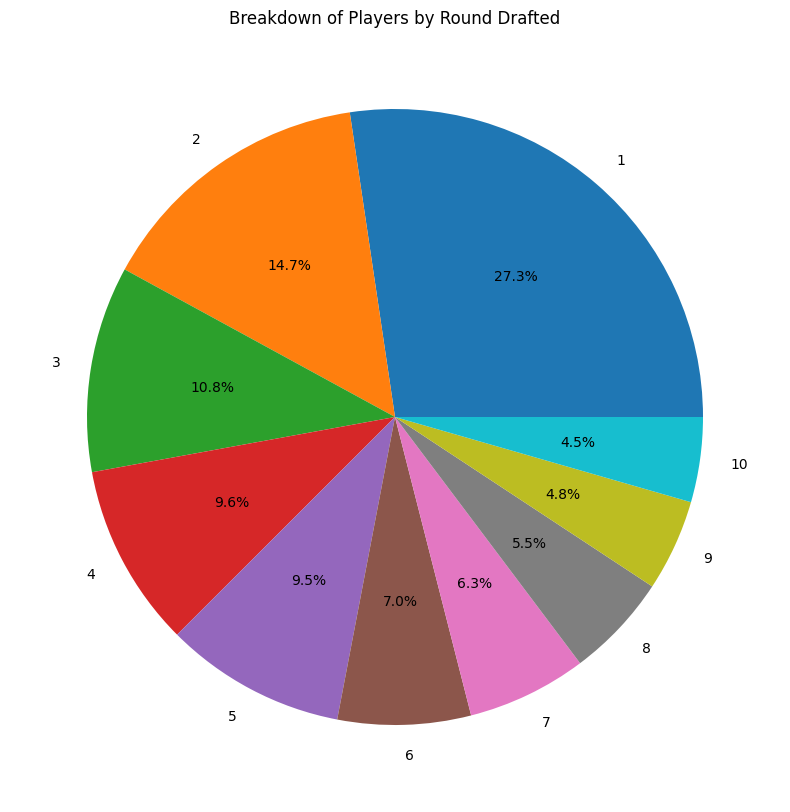

In [38]:
# Statistics of players that made it to the MLB and draft round
rounds = range(1, 11)
plt.figure(figsize=(12, 10))
plt.pie(master_df['RoundDrafted'].value_counts().values, labels=rounds, autopct='%1.1f%%')
plt.title('Breakdown of Players by Round Drafted')
plt.show()

##### All Stars by Round Visualization

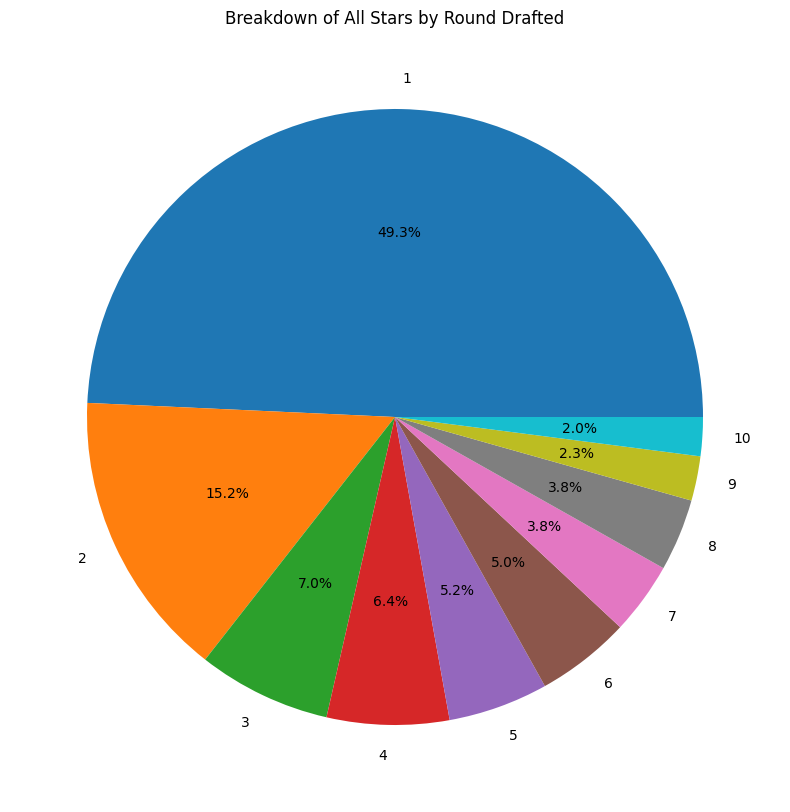

In [39]:
rounds = range(1, 11)
all_stars_by_round = master_df.loc[master_df['AllStar'] == True, ['RoundDrafted']]
plt.figure(figsize=(12, 10))
plt.pie(all_stars_by_round.value_counts().values, labels=rounds, autopct='%1.1f%%')
plt.title('Breakdown of All Stars by Round Drafted')
plt.show()

#### Overall Draft Pick Visualizations

##### All Players by Overall Draft Pick Visualization

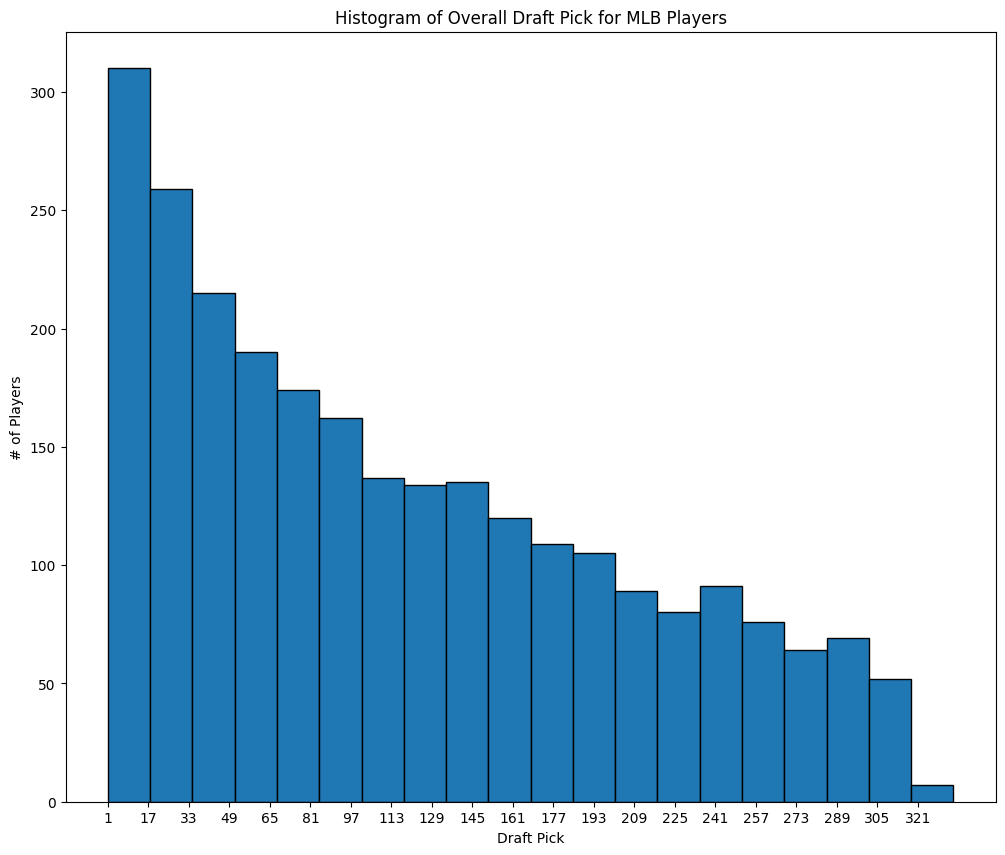

In [40]:
overall_pick = master_df['OvPck'].dropna()
max_overall_pick = overall_pick.max()

plt.figure(figsize=(12, 10))
plt.hist(overall_pick, bins=20, edgecolor='black')
plt.title('Histogram of Overall Draft Pick for MLB Players')
plt.xlabel('Draft Pick')
plt.ylabel('# of Players')
plt.xticks(range(1,max_overall_pick,int(max_overall_pick/20)))
plt.show()

##### All Stars by Overall Draft Pick Visualization

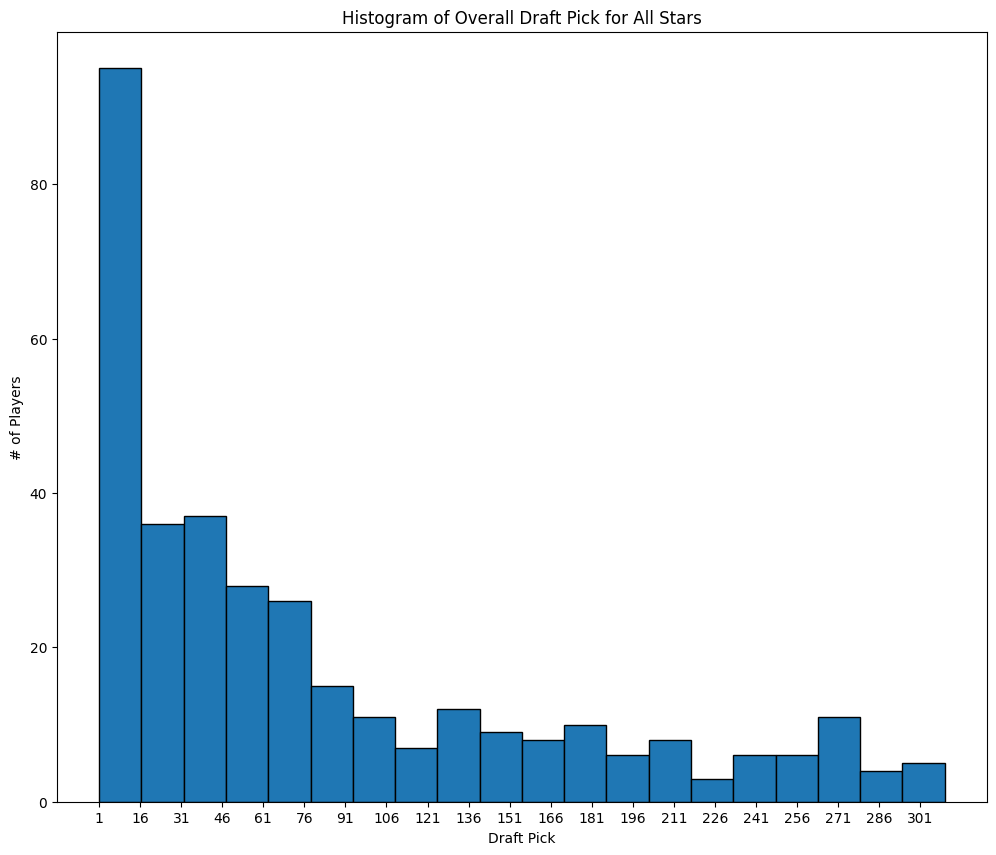

In [41]:
all_star_overall_pick = master_df.loc[master_df['AllStar'] == True, ['OvPck']]
max_all_star_overall_pick = all_star_overall_pick.max().iloc[0]

plt.figure(figsize=(12, 10))
plt.hist(all_star_overall_pick, bins=20, edgecolor='black')
plt.title('Histogram of Overall Draft Pick for All Stars')
plt.xlabel('Draft Pick')
plt.ylabel('# of Players')
plt.xticks(range(1,max_all_star_overall_pick,int(max_all_star_overall_pick/20)))
plt.show()

#### Team Visualizations

##### All Players by Team Visualization

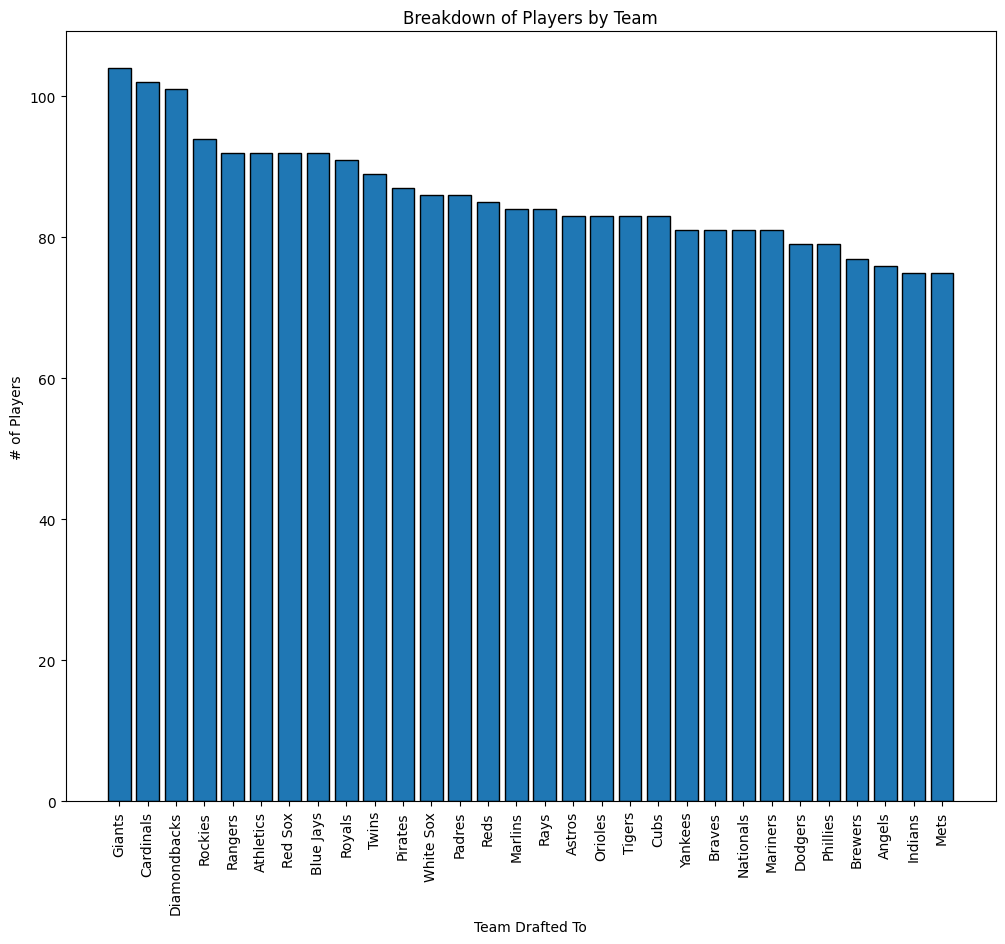

In [42]:
players_by_team = master_df['Team'].value_counts().reset_index()
players_by_team = players_by_team.loc[players_by_team['count'] != 0]
teams = players_by_team['Team'].tolist()
values = players_by_team['count'].tolist()
plt.figure(figsize=(12, 10))
plt.bar(teams, values, edgecolor='black', align='center')
plt.title('Breakdown of Players by Team')
plt.xlabel('Team Drafted To')
plt.ylabel('# of Players')
plt.xticks(teams, rotation=90)
plt.show()

##### All Stars by Team

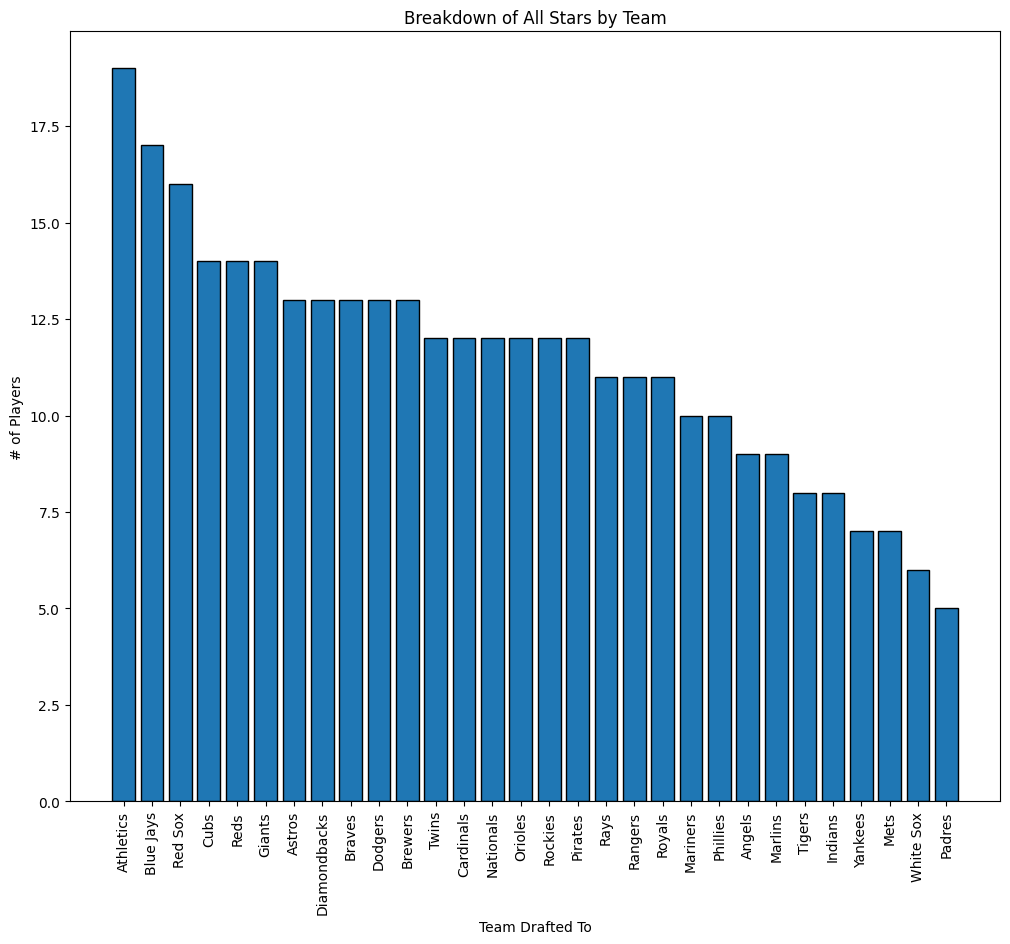

In [43]:
players_by_team = master_df.loc[master_df['AllStar'] == True]['Team'].value_counts().reset_index()
players_by_team = players_by_team.loc[players_by_team['count'] != 0]
teams = players_by_team['Team'].tolist()
values = players_by_team['count'].tolist()
plt.figure(figsize=(12, 10))
plt.bar(teams, values, edgecolor='black', align='center')
plt.title('Breakdown of All Stars by Team')
plt.xlabel('Team Drafted To')
plt.ylabel('# of Players')
plt.xticks(teams, rotation=90)
plt.show()

#### College Attendance Visualizations

##### All Players by College Attendance Visualization

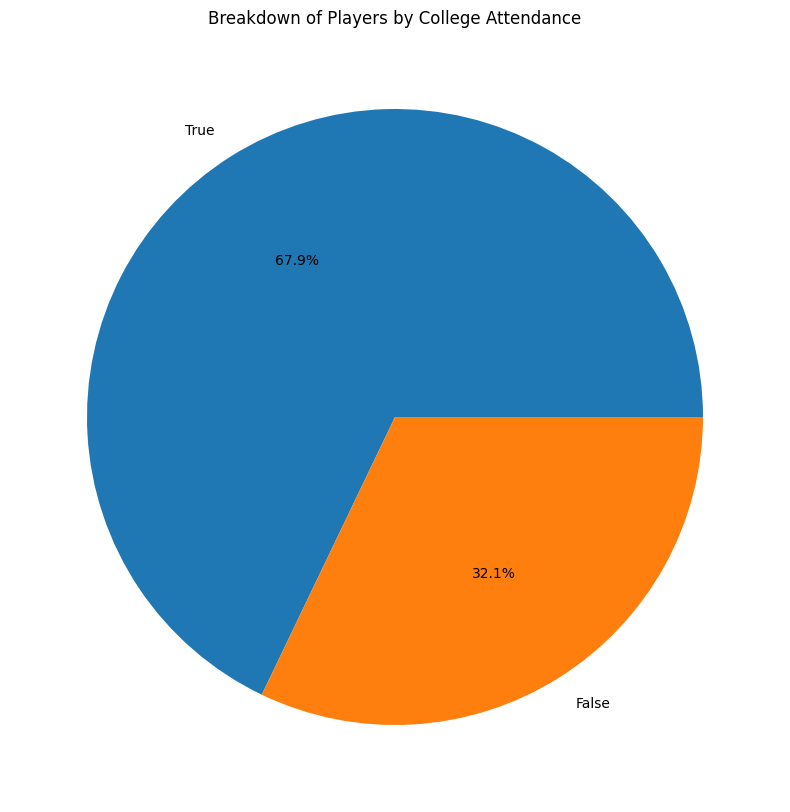

In [44]:
players_by_college = master_df['College'].value_counts().reset_index()

plt.figure(figsize=(12, 10))
plt.pie(players_by_college['count'].to_list(), labels=["True", "False"], autopct='%1.1f%%')
plt.title('Breakdown of Players by College Attendance')
plt.show()

##### All Stars by College Attendance Visualization

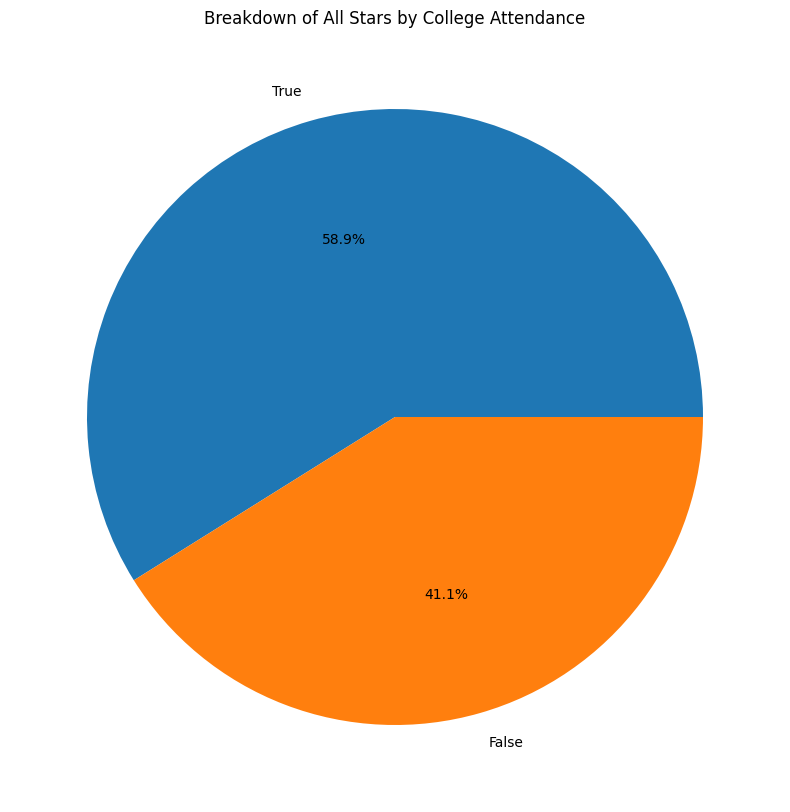

In [45]:
players_by_college = master_df.loc[master_df['AllStar'] == True]['College'].value_counts().reset_index()

plt.figure(figsize=(12, 10))
plt.pie(players_by_college['count'].to_list(), labels=["True", "False"], autopct='%1.1f%%')
plt.title('Breakdown of All Stars by College Attendance')
plt.show()

#### Years of Development Visualizations

##### All Players by Years of Development Visualizations

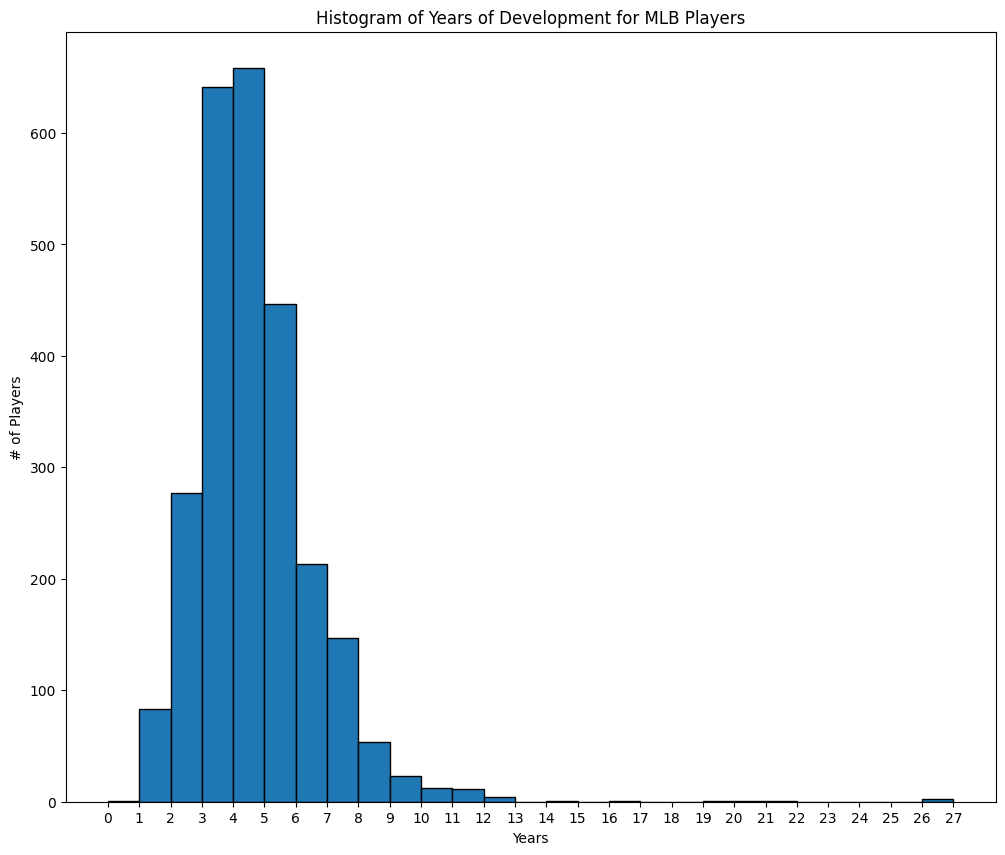

In [46]:
years_of_development = master_df['YoD'].dropna()
min_years = years_of_development.min()
max_years = years_of_development.max()

plt.figure(figsize=(12, 10))
plt.hist(years_of_development, bins=int(max_years-min_years), edgecolor='black')
plt.title('Histogram of Years of Development for MLB Players')
plt.xlabel('Years')
plt.ylabel('# of Players')
plt.xticks(range(int(max_years-min_years+1)))
plt.show()

##### All Stars by Years of Development Visualizations

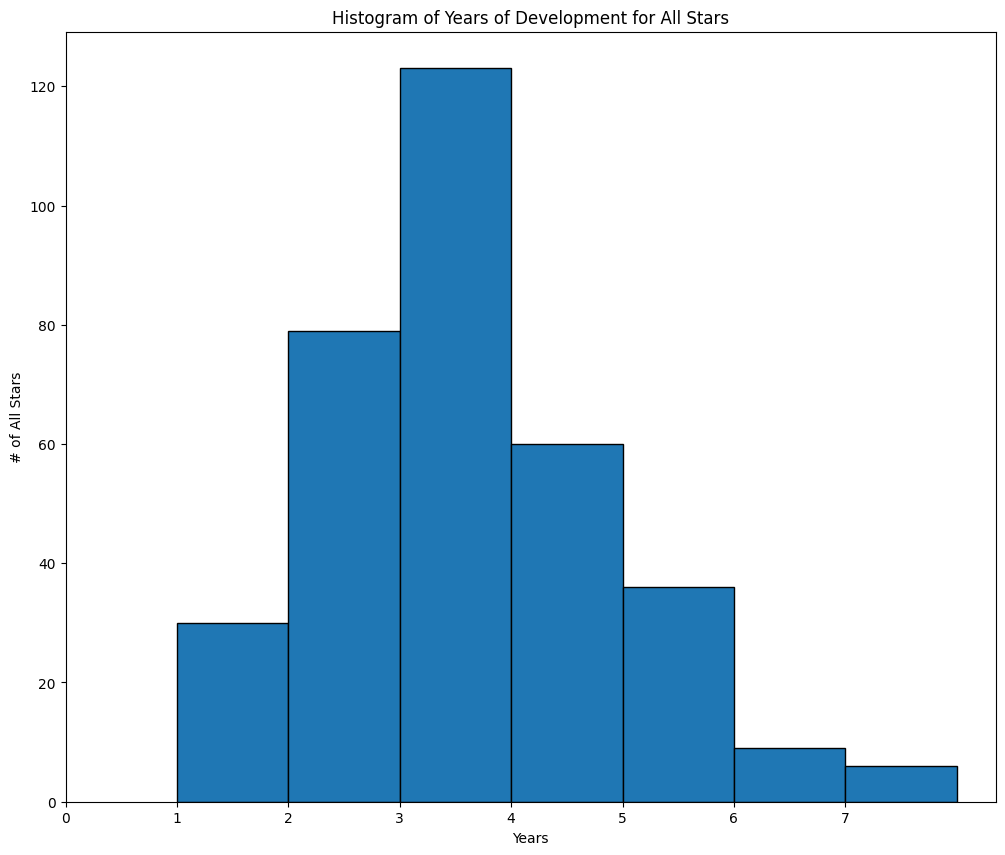

In [47]:
all_star_years_of_development = master_df.loc[master_df['AllStar'] == True, ['YoD']].dropna()
min_years = int(all_star_years_of_development.min().iloc[0])
max_years = int(all_star_years_of_development.max().iloc[0])

plt.figure(figsize=(12, 10))
plt.hist(all_star_years_of_development, bins=(max_years-min_years), edgecolor='black')
plt.title('Histogram of Years of Development for All Stars')
plt.xlabel('Years')
plt.ylabel('# of All Stars')
plt.xticks(range(max_years-min_years+1))
plt.show()

#### Country Visualizations

##### All Players by Country Visualization

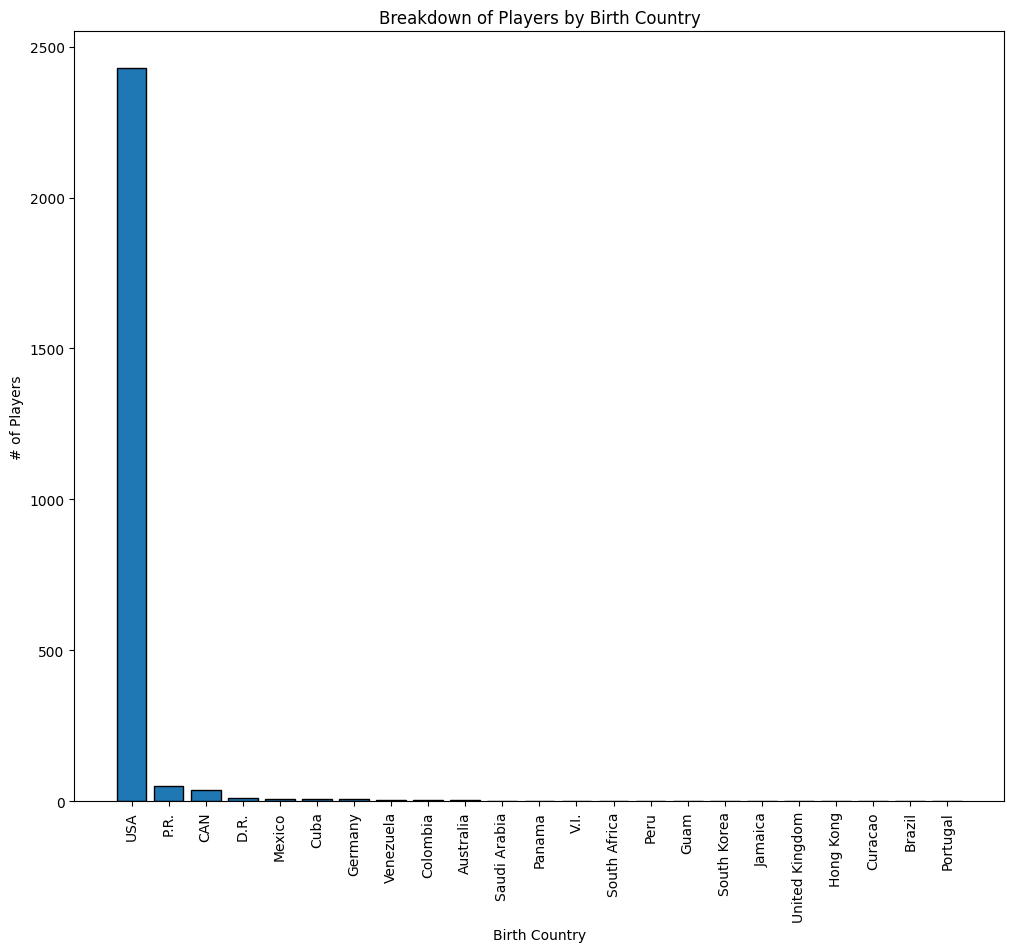

In [48]:
players_by_country = master_df['BirthCountry'].value_counts().reset_index()
players_by_country = players_by_country.loc[players_by_country['count'] != 0]
countries = players_by_country['BirthCountry'].tolist()
values = players_by_country['count'].tolist()
plt.figure(figsize=(12, 10))
plt.bar(countries, values, edgecolor='black', align='center')
plt.title('Breakdown of Players by Birth Country')
plt.xlabel('Birth Country')
plt.ylabel('# of Players')
plt.xticks(countries, rotation=90)
plt.show()

##### All Stars by Country Visualization

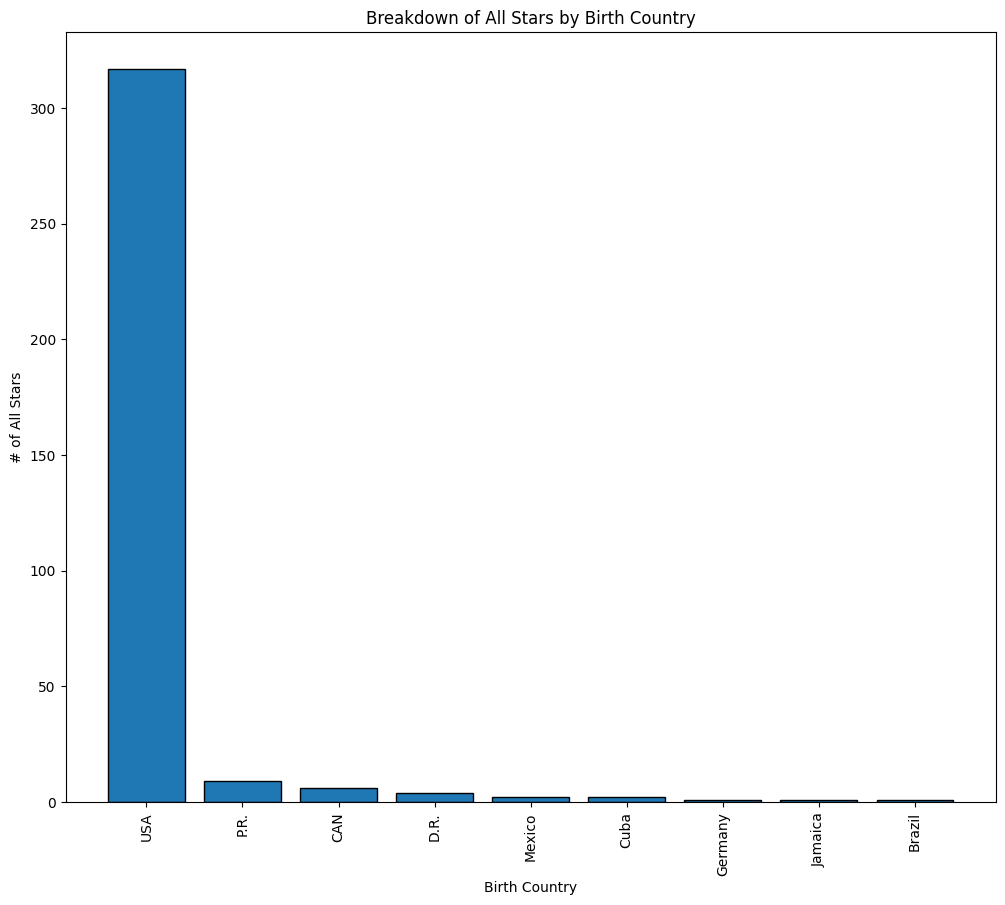

In [49]:
players_by_country = master_df.loc[master_df['AllStar'] == True]['BirthCountry'].value_counts().reset_index()
countries = players_by_country['BirthCountry'].tolist()
values = players_by_country['count'].tolist()
plt.figure(figsize=(12, 10))
plt.bar(countries, values, edgecolor='black', align='center')
plt.title('Breakdown of All Stars by Birth Country')
plt.xlabel('Birth Country')
plt.ylabel('# of All Stars')
plt.xticks(countries, rotation=90)
plt.show()

#### State Visualizations

##### USA Players by State Visualization

In [ ]:
import geopandas
states = geopandas.read_file('../data/states/usa-states-census-2014.shp')
type(states)
states = states.to_crs("EPSG:3395")

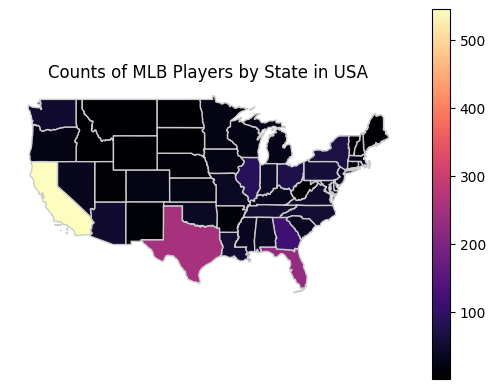

In [51]:
usa_players = master_df.loc[master_df['BirthCountry'] == 'USA'].reset_index(drop=True)
players_by_state = usa_players['BirthState'].value_counts().reset_index()
players_by_state = players_by_state.rename(columns={'BirthState': 'STUSPS'})
states_map = states.merge(players_by_state, on='STUSPS', how='left')
plot = states_map.plot(column='count', cmap="magma", edgecolor='0.8', legend=True)
plot.set_title("Counts of MLB Players by State in USA")
plot.set_axis_off()

##### USA All Stars by State Visualization

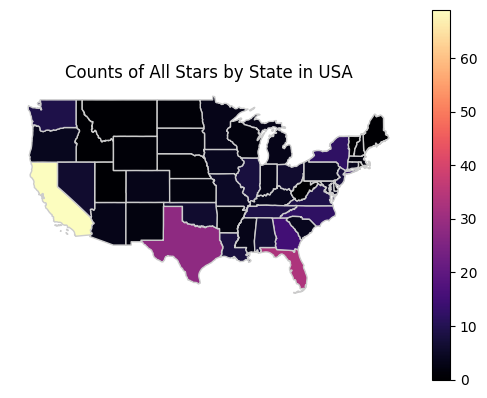

In [52]:
usa_players = master_df.loc[master_df['BirthCountry'] == 'USA'].reset_index(drop=True)
all_stars_by_state = usa_players.loc[usa_players['AllStar'] == True]['BirthState'].value_counts().reset_index()
all_stars_by_state = all_stars_by_state.rename(columns={'BirthState': 'STUSPS'})
states_map = states.merge(all_stars_by_state, on='STUSPS', how='left')
states_map['count'] = states_map['count'].fillna(0)
plot = states_map.plot(column='count', cmap="magma", edgecolor='0.8', legend=True)
plot.set_title("Counts of All Stars by State in USA")
plot.set_axis_off()

## Final Models

The classification models selected for this project are SVM, Logistic Regression, Decision Tree, kNN, Multilayer Perceptron, Random Forest, and Gradient Boosting. Each of these models has advantages and disadvantages and thus it is worth testing to see which model performs the best with the data. Due to the unbalanced nature of the dataset, each of the models will be trained on a balanced and unbalanced dataset. The performance will be measured with two metrics. The F1-score will be the primary metric for recursive feature elimination and hyperparameter tuning. F1-score was selected because of its ability to accurately score dataset with severe imbalances (only 13% of the dataset are All Stars). This will ensure that the number of false positives and false negatives are reduced. Other metrics such as accuracy, precision, and recall are recorded but not used in the model tuning process. The precision will be the secondary metric because it provides insight into the number of false positives that the model has. False positives are determinantal to teams because the teams would be giving All Star contracts to players that are not All Stars. This would drain resources and ultimately hurt the team in the future because the team would not be able to pay real All Star talent. In addition, each of the features are based solely on player characteristics and not their on field statistics. This helped simplify the feature engineering and EDA of this project

### Initial Setup & Helpful Functions

In [ ]:
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create an 80%-20% training-test split
training_split = 0.8

# Dataframe to store model statics and best params / features
column_names = ['Model', 'Balanced', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'RFE #', 'RFE Features', 'Best Params']
scoring_df = pd.DataFrame(columns=column_names)

feature_columns = ['OvPck', 'Team', 'College', 'RoundDrafted', 'BirthCountry', 'BirthState', 'YoD', 'DebutAge']
target_column = ['AllStar']
players_data_df = pd.read_csv('../data/master_df.csv', index_col=False).iloc[:,1:] # ignore index column
players_data_df.head()

,OvPck,Team,College,YearDrafted,RoundDrafted,FirstName,LastName,PlayerId,Debut,BirthCountry,BirthState,BirthYear,AllStar,YoD,DebutAge
0,1,Angels,1,1995,1,Darin,Erstad,erstada01,1996.0,USA,ND,1974.0,1,1.0,22.0
1,2,Padres,0,1995,1,Ben,Davis,davisbe01,1998.0,USA,PA,1977.0,0,3.0,21.0
2,3,Mariners,1,1995,1,José,Cruz,cruzjo02,1997.0,P.R.,NaN,1974.0,0,2.0,23.0
3,4,Cubs,0,1995,1,Kerry,Wood,woodke02,1998.0,USA,TX,1977.0,1,3.0,21.0
4,7,Rangers,1,1995,1,Jonathan,Johnson,johnsjo08,1998.0,USA,GA,1974.0,0,3.0,24.0


In [54]:
# Create a list of the unique teams, countries, and states
teams = players_data_df['Team'].unique().tolist()
countries = players_data_df['BirthCountry'].unique().tolist()
states = players_data_df['BirthState'].unique().tolist()
teams_dict = {}
countries_dict = {}
states_dict = {}
# Create a dictionary with the string as the key and the index as the value
for i, team in enumerate(teams):
    teams_dict[team] = i
for i, country in enumerate(countries):
    countries_dict[country] = i
for i, state in enumerate(states):
    states_dict[state] = i

# Map the dictionary values into the column based on the dictionary key
players_data_df.loc[:, 'Team'] = players_data_df['Team'].map(teams_dict)
players_data_df.loc[:, 'BirthCountry'] = players_data_df['BirthCountry'].map(countries_dict)
players_data_df.loc[:, 'BirthState'] = players_data_df['BirthState'].map(states_dict)

# Replace bool with respective 1 or 0
players_data_df.loc[:, 'College'] = players_data_df['College'].astype(bool).astype(int)
players_data_df.loc[:, 'AllStar'] = players_data_df['AllStar'].astype(bool).astype(int)

players_data_df.head()

,OvPck,Team,College,YearDrafted,RoundDrafted,FirstName,LastName,PlayerId,Debut,BirthCountry,BirthState,BirthYear,AllStar,YoD,DebutAge
0,1,0,1,1995,1,Darin,Erstad,erstada01,1996.0,0,0,1974.0,1,1.0,22.0
1,2,1,0,1995,1,Ben,Davis,davisbe01,1998.0,0,1,1977.0,0,3.0,21.0
2,3,2,1,1995,1,José,Cruz,cruzjo02,1997.0,1,2,1974.0,0,2.0,23.0
3,4,3,0,1995,1,Kerry,Wood,woodke02,1998.0,0,3,1977.0,1,3.0,21.0
4,7,4,1,1995,1,Jonathan,Johnson,johnsjo08,1998.0,0,4,1974.0,0,3.0,24.0


In [55]:
## Helpful functions and variables
n_features = len(feature_columns)

# Make a scoring variable to be used to score hyperparameters and recursive feature elimination
scorer = make_scorer(f1_score)

# Returns the highest performing model based on the passed hyperparameter
# GridSearchCV will preform 10 cross validations to increase the robustness and training data
def get_best_model(model, hyperparams, X_train, y_train, X_test, y_test):
    model_search_params = GridSearchCV(model, hyperparams, scoring=scorer, cv=10, n_jobs=-1)
    model_search_params.fit(X_train, y_train)
    preds = model_search_params.best_estimator_.predict(X_test)
    metrics = get_metrics(y_test, preds)
    return metrics, model_search_params.best_params_

# Adds the metrics, best features, and best hyperparameters per model
def add_to_dataframe(model_name, balanced, metrics, rfe, params):
    global scoring_df
    row = pd.DataFrame([{column_names[0]: model_name, 
                        column_names[1]: balanced, 
                        column_names[2]: metrics[0], 
                        column_names[3]: metrics[1], 
                        column_names[4]: metrics[2],
                        column_names[5]: metrics[3], 
                        column_names[6]: len(feature_columns) if rfe is None else len(get_feature_names(rfe)),
                        column_names[7]: feature_columns if rfe is None else get_feature_names(rfe).tolist(),
                        column_names[8]: str(params)}])
    scoring_df = pd.concat([scoring_df, row], ignore_index=True)
    
# Gets the feature names from the recursive feature elimination ranking
def get_feature_names(rfe):
    return np.array(feature_columns)[np.where(rfe.ranking_ == 1)[0]]

# Print and return the accuracy, precision, recall, f1 for a model
def get_metrics(test_values, pred_values):
    accuracy = accuracy_score(test_values, pred_values)
    precision = precision_score(test_values, pred_values, zero_division=0)
    recall = recall_score(test_values, pred_values, zero_division=0)
    f1 = f1_score(test_values, pred_values, zero_division=0)

    # print("accuracy: ", accuracy)
    # print("precision: ", precision)
    # print("recall: ", recall)
    # print("f1:", f1)
    
    return [accuracy, precision, recall, f1]

# Calculate the f1 score and accuracy with rfe
def calculate_metrics_with_rfe(model, n_features, X_train, X_test, y_train, y_test):
    rfe = RFE(estimator=model, n_features_to_select=n_features, step=1)
    rfe.fit(X_train, y_train.ravel())
    y_pred = rfe.predict(X_test)
    return (get_metrics(y_test, y_pred), rfe)

# Plot metrics, print best features for the model, and return highest performing model
def features_vs_metrics(model, X_train, X_test, y_train, y_test):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    rfes = []
    # Get the best model from 1 to n features and record metrics
    for i in range(1,n_features+1):
        metrics, rfe = calculate_metrics_with_rfe(model, i, X_train, X_test, y_train, y_test)
        accuracies.append(metrics[0])
        precisions.append(metrics[1])
        recalls.append(metrics[2])
        f1_scores.append(metrics[3])
        rfes.append(rfe)

    # Get the index of the rfes with the highest f1 score
    max_f1_score = max(f1_scores)
    max_f1_score_index = f1_scores.index(max_f1_score)
    # Prints the highest performing featues
    print(get_feature_names(rfes[max_f1_score_index]))

    # Plot the metrics from 1 to n features
    plt.plot(range(1,n_features+1), accuracies, label='accuracy', linestyle='--')
    plt.plot(range(1,n_features+1), precisions, label='precision', linestyle='-.')
    plt.plot(range(1,n_features+1), recalls, label='recall', linestyle=':', color='black')
    plt.plot(range(1,n_features+1), f1_scores, label='f1_score', linestyle='-', alpha=.5, color='red')
    plt.legend()
    plt.xticks(range(1,n_features+1))
    plt.xlabel("# of features")
    plt.ylabel("Metric Score")
    plt.title("# of Features vs. Metric Score")
    return rfes[max_f1_score_index]


### Unbalanced Models Training and Testing

In [56]:
# Create a Bunch to make model analysis easier
players_data = Bunch (
    data = players_data_df[feature_columns].values,
    target = players_data_df[target_column].values,
    feature_names = feature_columns,
    target_names = target_column,
    description = "MLB player draft, origin, development, and All Star data"
)

# Print the ratio of All Stars to non All Stars
ratio = players_data_df['AllStar'].value_counts()/players_data.data.shape[0]
print(ratio)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(players_data.data, players_data.target, train_size=training_split, test_size=(1-training_split), shuffle=False)
flattened_y_train = y_train.ravel()

AllStar
0    0.866951
1    0.133049
Name: count, dtype: float64


#### Recursive feature elimination

['OvPck' 'College' 'RoundDrafted' 'BirthCountry' 'BirthState' 'YoD'
 'DebutAge']


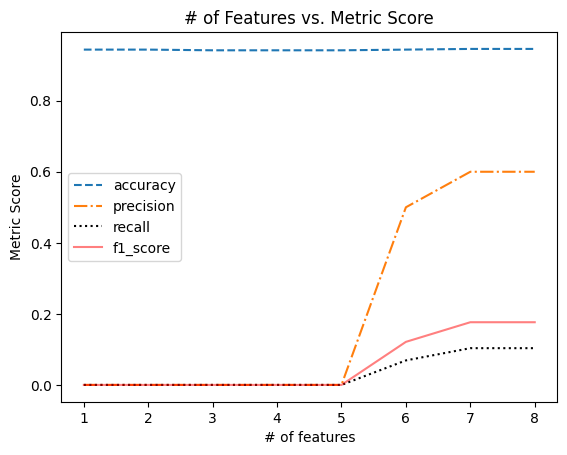

In [57]:
# Plot the metrics for Logistic Regression Model
clf_log = LogisticRegression(max_iter=1000)
# Save the highest performing model
clf_log_rfe = features_vs_metrics(clf_log, X_train, X_test, y_train, y_test)

['RoundDrafted']


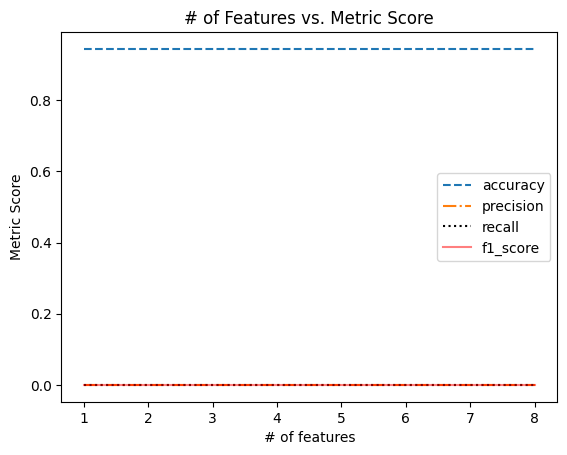

In [58]:
# Plot the metrics for SVM (linear) Model
clf_linear = SVC(kernel='linear')
# Save the highest performing model
clf_linear_rfe = features_vs_metrics(clf_linear, X_train, X_test, y_train, y_test)

In [59]:
# Save the highest performing model SVM (Non-linear)
clf_non_linear = SVC(kernel='rbf')
clf_non_linear.fit(X_train, y_train)
y_preds = clf_non_linear.predict(X_test)
clf_non_linear_metrics = get_metrics(y_test, y_preds)

/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['OvPck' 'Team' 'BirthState' 'YoD' 'DebutAge']


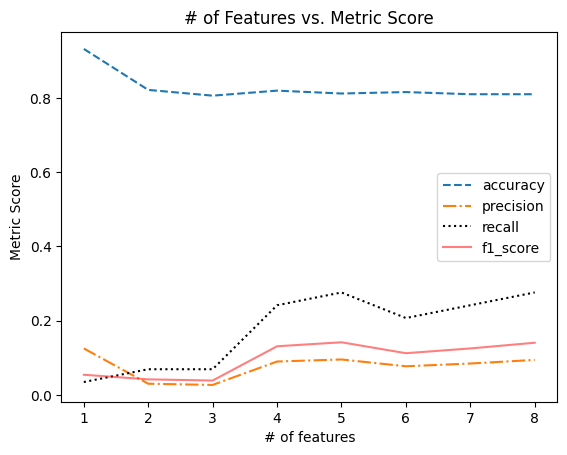

In [60]:
# Plot the metrics for Decision Tree Model
clf_dtc = DecisionTreeClassifier()
# Save the highest performing model
clf_dtc_rfe = features_vs_metrics(clf_dtc, X_train, X_test, y_train, y_test)

['OvPck' 'Team' 'BirthState' 'DebutAge']


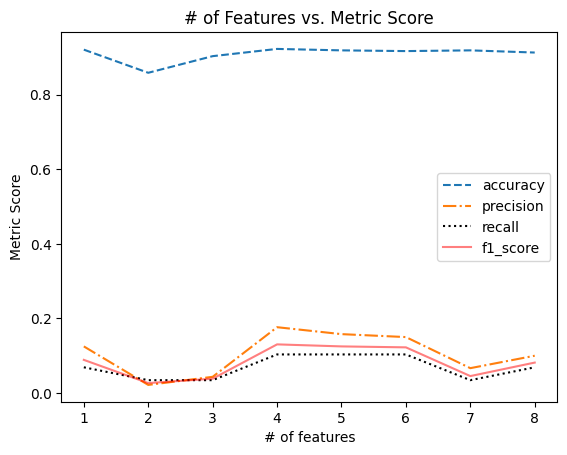

In [61]:
# Plot the metrics for Random Forest Model
clf_rfc = RandomForestClassifier()
# Save the highest performing model
clf_rfc_rfe = features_vs_metrics(clf_rfc, X_train, X_test, y_train, y_test)

In [62]:
# Save the highest performing model kNN
clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_knn.fit(X_train, y_train)
y_preds = clf_knn.predict(X_test)
clf_knn_metrics = get_metrics(y_test, y_preds)
print(clf_knn_metrics)

[0.9166666666666666, np.float64(0.15), np.float64(0.10344827586206896), np.float64(0.12244897959183673)]


/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [63]:
# Save the highest performing model Multilayer Perceptron
clf_mlp = MLPClassifier(max_iter = 1000)
clf_mlp.fit(X_train, y_train)
y_preds = clf_mlp.predict(X_test)
clf_mlp_metrics = get_metrics(y_test, y_preds)
print(clf_mlp_metrics)

/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.9321705426356589, np.float64(0.125), np.float64(0.034482758620689655), np.float64(0.05405405405405406)]


In [64]:
# Save the highest performing model Gradient Boosting
clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train, y_train)
y_preds = clf_gb.predict(X_test)
clf_gb_metrics = get_metrics(y_test, y_preds)
print(clf_gb_metrics)

[0.9282945736434108, np.float64(0.25), np.float64(0.13793103448275862), np.float64(0.17777777777777778)]


/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Hyperperamter Tuning for Logistic Regression, SVM (Linear/Non-Linear) and Decision Tree after RFE

In [65]:
# Logistic Regression RFE Best Model with Hyperparameter Tuning
X_train_rfe = X_train[:, clf_log_rfe.support_]
X_test_rfe = X_test[:, clf_log_rfe.support_]

log_parameters = {'solver': ['newton-cg', 'lbfgs', 'newton-cholesky', 'sag', 'saga'],
                    'penalty': ['l2'],
                    'C': np.arange(1, 25, 1)}

clf_log_rfe_best_model = get_best_model(LogisticRegression(max_iter=10000), log_parameters, X_train_rfe, flattened_y_train, X_test_rfe, y_test)
add_to_dataframe('Logistic Regression', False, clf_log_rfe_best_model[0], clf_log_rfe, clf_log_rfe_best_model[1])

/var/folders/z8/c4f7q6w57gggs71gp2lbk9t40000gn/T/ipykernel_22263/3875167752.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scoring_df = pd.concat([scoring_df, row], ignore_index=True)


In [66]:
# SVM (Linear) RFE Best Model with Hyperparameter Tuning
X_train_rfe = X_train[:, clf_linear_rfe.support_]
X_test_rfe = X_test[:, clf_linear_rfe.support_]

linear_parameters = {'C': np.arange(.1, 2, .1),
                      'gamma': ['scale', 'auto']}

clf_linear_rfe_best_model = get_best_model(SVC(kernel='linear'), linear_parameters, X_train_rfe, flattened_y_train, X_test_rfe, y_test)
add_to_dataframe('SVM (Linear)', False, clf_linear_rfe_best_model[0], clf_linear_rfe, clf_linear_rfe_best_model[1])

In [67]:
# SVM (Non-linear) Model with Hyperparameter Tuning
non_linear_parameters = {'C': np.arange(.1, 2, .1),
                      'gamma': ['scale', 'auto']}
clf_non_linear = get_best_model(SVC(kernel='rbf'), non_linear_parameters, X_train, flattened_y_train, X_test, y_test)
add_to_dataframe('SVM (Non-Linear)', False, clf_non_linear[0], None, clf_non_linear[1])

In [68]:
# Decision Tree RFE Best Model with Hyperparameter Tuning
X_train_rfe = X_train[:, clf_dtc_rfe.support_]
X_test_rfe = X_test[:, clf_dtc_rfe.support_]

dtc_parameters = {'criterion': ["gini", "entropy", "log_loss"],
                      'max_depth': [1, 5, 10, None],
                      'ccp_alpha': [0.0, 0.5, 1.0]}

clf_dtc_rfe_best_model = get_best_model(DecisionTreeClassifier(), dtc_parameters, X_train_rfe, flattened_y_train, X_test_rfe, y_test)
add_to_dataframe('Decision Tree', False, clf_dtc_rfe_best_model[0], clf_dtc_rfe, clf_dtc_rfe_best_model[1])

In [69]:
# Random Forest RFE Best Model with Hyperparameter Tuning
X_train_rfe = X_train[:, clf_rfc_rfe.support_]
X_test_rfe = X_test[:, clf_rfc_rfe.support_]

rfc_parameters = {'criterion': ["gini", "entropy", "log_loss"],
                      'n_estimators': [100, 500, 1000, 10000],
                      'max_depth': [1, 5, 10, None],
                      'ccp_alpha': [0.0, 0.5, 1.0]}

clf_rfc_rfe_best_model = get_best_model(RandomForestClassifier(), rfc_parameters, X_train_rfe, flattened_y_train, X_test_rfe, y_test)
add_to_dataframe('Random Forest', False, clf_rfc_rfe_best_model[0], clf_rfc_rfe, clf_rfc_rfe_best_model[1])

/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [70]:
# kNN Model with Hyperparameter Tuning
knn_parameters = {'n_neighbors': np.arange(5, 15, 2),
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan', 'minkowski']}
clf_knn = get_best_model(KNeighborsClassifier(), knn_parameters, X_train, flattened_y_train, X_test, y_test)
add_to_dataframe('kNN', False, clf_knn[0], None, clf_knn[1])

In [71]:
# MLP Model with Hyperparameter Tuning
mlp_parameters = {'hidden_layer_sizes': [(400, 50), (400, 25), (400, 10),
                                         (300, 50), (300, 25), (300, 10),
                                         (200, 50), (200, 25), (200, 10),
                                         (100, 50), (100, 25), (100, 10)],
                  'activation': ['relu', 'tanh'],
                  'learning_rate': ['constant', 'invscaling', 'adaptive']}
clf_mlp = get_best_model(MLPClassifier(max_iter=1000), mlp_parameters, X_train, flattened_y_train, X_test, y_test)
add_to_dataframe('MLP', False, clf_mlp[0], None, clf_mlp[1])

In [72]:
# Gradient Boosting Model with Hyperparameter Tuning
gb_parameters = {'loss': ['log_loss', 'exponential'],
                  'learning_rate': [.1, .5],
                  'criterion': ['friedman_mse', 'squared_error'],
                  'n_estimators': [100, 250, 500]}
clf_gb = get_best_model(GradientBoostingClassifier(), gb_parameters, X_train, flattened_y_train, X_test, y_test)
add_to_dataframe('Gradient Boosting', False, clf_gb[0], None, clf_gb[1])

### Balanced Models Training and Testing

#### Recursive feature elimination

In [73]:
from imblearn.over_sampling import ADASYN

# Use ADASYN to make the classes equal
adasyn = ADASYN(random_state=33)
X = players_data_df[feature_columns]
y = players_data_df[target_column]
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
df_adasyn = pd.DataFrame(X_adasyn, columns=feature_columns)
df_adasyn[target_column] = y_adasyn
df_adasyn.reset_index(drop=True, inplace=True)

In [74]:
# Create a Bunch to make model analysis easier
players_data = Bunch (
    data = df_adasyn[feature_columns].values,
    target = df_adasyn[target_column].values,
    feature_names = feature_columns,
    target_names = target_column,
    description = "Balanced MLB player draft, origin, development, and All Star data"
)

# Print the ratio of All Stars to non All Stars
ratio = df_adasyn['AllStar'].value_counts()/players_data.data.shape[0]
print(ratio)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(players_data.data, players_data.target, train_size=training_split, test_size=(1-training_split), shuffle=False)
flattened_y_train = y_train.ravel()

AllStar
0    0.502473
1    0.497527
Name: count, dtype: float64


['College']


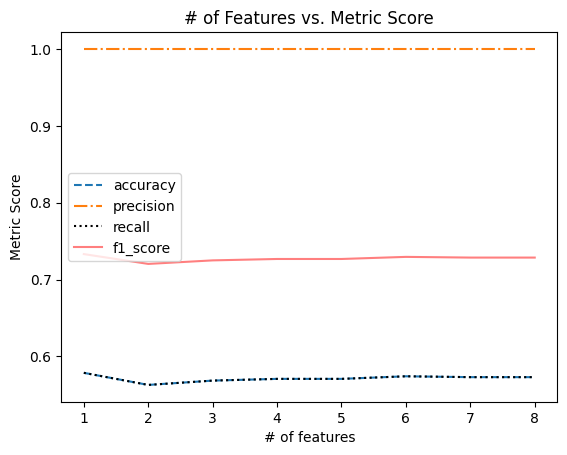

In [75]:
# Plot the metrics for Logistic Regression Model
bal_clf_log = LogisticRegression(max_iter=1000)
# Save the highest performing model
bal_clf_log_rfe = features_vs_metrics(bal_clf_log, X_train, X_test, y_train, y_test)

['College']


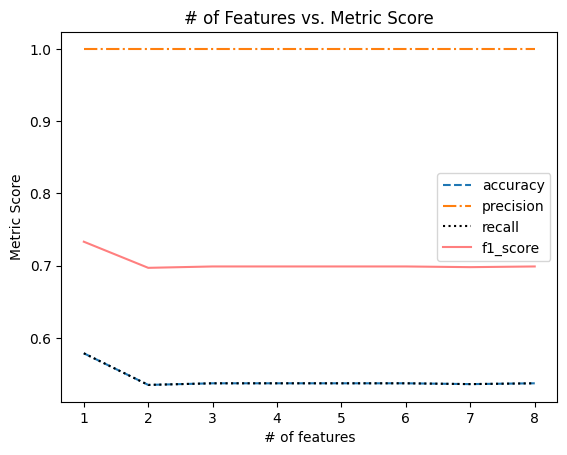

In [76]:
# Plot the metrics for SVM (linear) Model
bal_clf_linear = SVC(kernel='linear')
# Save the highest performing model
bal_clf_linear_rfe = features_vs_metrics(clf_linear, X_train, X_test, y_train, y_test)

In [77]:
# Save the highest performing model SVM (Non-linear)
bal_clf_non_linear = SVC(kernel='rbf')
bal_clf_non_linear.fit(X_train, y_train)
y_preds = bal_clf_non_linear.predict(X_test)
bal_clf_non_linear_metrics = get_metrics(y_test, y_preds)

/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['OvPck' 'Team' 'College' 'RoundDrafted' 'BirthCountry' 'BirthState' 'YoD'
 'DebutAge']


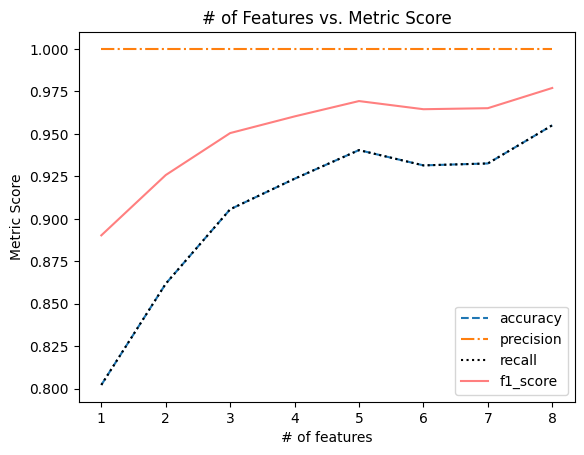

In [78]:
# Plot the metrics for Decision Tree Model
bal_clf_dtc = DecisionTreeClassifier()
# Save the highest performing model
bal_clf_dtc_rfe = features_vs_metrics(bal_clf_dtc, X_train, X_test, y_train, y_test)

['OvPck' 'Team' 'BirthState' 'YoD' 'DebutAge']


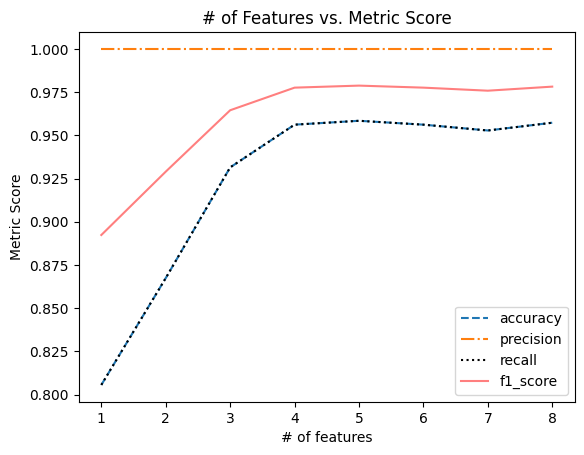

In [79]:
# Plot the metrics for Random Forest Model
bal_clf_rfc = RandomForestClassifier()
# Save the highest performing model
bal_clf_rfc_rfe = features_vs_metrics(bal_clf_rfc, X_train, X_test, y_train, y_test)

In [80]:
# Save the highest performing model kNN
bal_clf_knn = KNeighborsClassifier(n_neighbors = 5)
bal_clf_knn.fit(X_train, y_train)
y_preds = bal_clf_knn.predict(X_test)
bal_clf_knn_metrics = get_metrics(y_test, y_preds)

/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [81]:
# Save the highest performing model Multilayer Perceptron
bal_clf_mlp = MLPClassifier(max_iter = 1000)
bal_clf_mlp.fit(X_train, y_train)
y_preds = bal_clf_mlp.predict(X_test)
bal_clf_mlp_metrics = get_metrics(y_test, y_preds)

/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [82]:
# Save the highest performing model Gradient Boosting
bal_clf_gb = GradientBoostingClassifier()
bal_clf_gb.fit(X_train, y_train)
y_preds = bal_clf_gb.predict(X_test)
bal_clf_gb_metrics = get_metrics(y_test, y_preds)
print(bal_clf_gb_metrics)

/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.9123595505617977, np.float64(1.0), np.float64(0.9123595505617977), np.float64(0.954171562867215)]


#### Hyperperamter Tuning for Logistic Regression, SVM (Linear/Non-Linear) and Decision Tree after RFE

In [83]:
# Logistic Regression RFE Best Model with Hyperparameter Tuning
X_train_rfe = X_train[:, bal_clf_log_rfe.support_]
X_test_rfe = X_test[:, bal_clf_log_rfe.support_]

log_parameters = {'solver': ['newton-cg', 'lbfgs', 'newton-cholesky', 'sag', 'saga'],
                    'penalty': ['l2'],
                    'C': np.arange(.1, 1, .1)}
bal_clf_log_rfe_best_model = get_best_model(LogisticRegression(max_iter=10000), log_parameters, X_train_rfe, flattened_y_train, X_test_rfe, y_test)
add_to_dataframe('Logistic Regression', True, bal_clf_log_rfe_best_model[0], bal_clf_log_rfe, bal_clf_log_rfe_best_model[1])

In [84]:
# SVM (Linear) RFE Best Model with Hyperparameter Tuning
X_train_rfe = X_train[:, bal_clf_linear_rfe.support_]
X_test_rfe = X_test[:, bal_clf_linear_rfe.support_]

linear_parameters = {'C': np.arange(.1, 2, .1),
                      'gamma': ['scale', 'auto']}

bal_clf_linear_rfe_best_model = get_best_model(SVC(kernel='linear'), linear_parameters, X_train_rfe, flattened_y_train, X_test_rfe, y_test)
add_to_dataframe('SVM (Linear)', True, bal_clf_linear_rfe_best_model[0], bal_clf_linear_rfe, bal_clf_linear_rfe_best_model[1])

In [85]:
# SVM (Non-linear) Model with Hyperparameter Tuning
non_linear_parameters = {'C': np.arange(.1, 2, .1),
                      'gamma': ['scale', 'auto']}
bal_clf_non_linear = get_best_model(SVC(kernel='rbf'), non_linear_parameters, X_train, flattened_y_train, X_test, y_test)
add_to_dataframe('SVM (Non-Linear)', True, bal_clf_non_linear[0], None, bal_clf_non_linear[1])

In [86]:
# Decision Tree RFE Best Model with Hyperparameter Tuning
X_train_rfe = X_train[:, bal_clf_dtc_rfe.support_]
X_test_rfe = X_test[:, bal_clf_dtc_rfe.support_]

bal_clf_dtc_rfe_model = DecisionTreeClassifier()
dtc_parameters = {'criterion': ["gini", "entropy", "log_loss"],
                      'max_depth': [1, 2, 3, 4, 5, None],
                      'ccp_alpha': np.arange(0, 1, .1)}

bal_clf_dtc_rfe_best_model = get_best_model(DecisionTreeClassifier(), dtc_parameters, X_train_rfe, flattened_y_train, X_test_rfe, y_test)
add_to_dataframe('Decision Tree', True, bal_clf_dtc_rfe_best_model[0], bal_clf_dtc_rfe, bal_clf_dtc_rfe_best_model[1])

In [87]:
# Random Forest RFE Best Model with Hyperparameter Tuning
X_train_rfe = X_train[:, bal_clf_rfc_rfe.support_]
X_test_rfe = X_test[:, bal_clf_rfc_rfe.support_]

bal_clf_rfc_rfe_model = RandomForestClassifier()
dtc_parameters = {'criterion': ["gini", "entropy", "log_loss"],
                      'n_estimators': [100, 500, 1000, 10000],
                      'max_depth': [1, 5, 10, None],
                      'ccp_alpha': np.arange(0, 1, .1)}

bal_clf_rfc_rfe_best_model = get_best_model(RandomForestClassifier(), rfc_parameters, X_train_rfe, flattened_y_train, X_test_rfe, y_test)
add_to_dataframe('Random Forest', True, bal_clf_rfc_rfe_best_model[0], bal_clf_rfc_rfe, bal_clf_rfc_rfe_best_model[1])

/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [88]:
# kNN Model with Hyperparameter Tuning
knn_parameters = {'n_neighbors': np.arange(5, 15, 2),
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan', 'minkowski']}
bal_clf_knn = get_best_model(KNeighborsClassifier(), knn_parameters, X_train, flattened_y_train, X_test, y_test)
add_to_dataframe('kNN', True, bal_clf_knn[0], None, bal_clf_knn[1])

In [89]:
# MLP Model with Hyperparameter Tuning
mlp_parameters = {'hidden_layer_sizes': [(400, 50), (400, 25), (400, 10),
                                         (300, 50), (300, 25), (300, 10),
                                         (200, 50), (200, 25), (200, 10),
                                         (100, 50), (100, 25), (100, 10)],
                  'activation': ['relu', 'tanh'],
                  'learning_rate': ['constant', 'invscaling', 'adaptive']}
bal_clf_mlp = get_best_model(MLPClassifier(max_iter=2000), mlp_parameters, X_train, flattened_y_train, X_test, y_test)
add_to_dataframe('MLP', True, bal_clf_mlp[0], None, bal_clf_mlp[1])

In [90]:
# Gradient Boosting Model with Hyperparameter Tuning
gb_parameters = {'loss': ['log_loss', 'exponential'],
                  'learning_rate': [.1, .5],
                  'criterion': ['friedman_mse', 'squared_error'],
                  'n_estimators': [100, 250, 500]}
bal_clf_gb = get_best_model(GradientBoostingClassifier(), gb_parameters, X_train, flattened_y_train, X_test, y_test)
add_to_dataframe('Gradient Boosting', True, bal_clf_gb[0], None, bal_clf_gb[1])

In [91]:
pd.options.display.max_colwidth = 500
sorted_scoring_df = scoring_df.sort_values("F1 Score", ascending=False)
sorted_scoring_df.head(len(sorted_scoring_df))

,Model,Balanced,Accuracy,Precision,Recall,F1 Score,RFE #,RFE Features,Best Params
12,Random Forest,True,0.959551,1.000000,0.959551,0.979358,5,"[OvPck, Team, BirthState, YoD, DebutAge]","{'ccp_alpha': 0.0, 'criterion': 'log_loss', 'max_depth': None, 'n_estimators': 10000}"
11,Decision Tree,True,0.953933,1.000000,0.953933,0.976423,8,"[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]","{'ccp_alpha': np.float64(0.0), 'criterion': 'gini', 'max_depth': None}"
15,Gradient Boosting,True,0.941573,1.000000,0.941573,0.969907,8,"[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]","{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 250}"
13,kNN,True,0.858427,1.000000,0.858427,0.923821,8,"[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]","{'metric': 'manhattan', 'n_neighbors': np.int64(5), 'weights': 'distance'}"
10,SVM (Non-Linear),True,0.714607,1.000000,0.714607,0.833552,8,"[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]","{'C': np.float64(1.9000000000000001), 'gamma': 'auto'}"
14,MLP,True,0.698876,1.000000,0.698876,0.822751,8,"[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]","{'activation': 'tanh', 'hidden_layer_sizes': (100, 25), 'learning_rate': 'constant'}"
8,Logistic Regression,True,0.578652,1.000000,0.578652,0.733096,1,[College],"{'C': np.float64(0.1), 'penalty': 'l2', 'solver': 'newton-cg'}"
9,SVM (Linear),True,0.578652,1.000000,0.578652,0.733096,1,[College],"{'C': np.float64(0.1), 'gamma': 'scale'}"
0,Logistic Regression,False,0.945736,0.600000,0.103448,0.176471,7,"[OvPck, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]","{'C': np.int64(4), 'penalty': 'l2', 'solver': 'newton-cg'}"
3,Decision Tree,False,0.813953,0.114943,0.344828,0.172414,5,"[OvPck, Team, BirthState, YoD, DebutAge]","{'ccp_alpha': 0.0, 'criterion': 'log_loss', 'max_depth': None}"


### Model Results

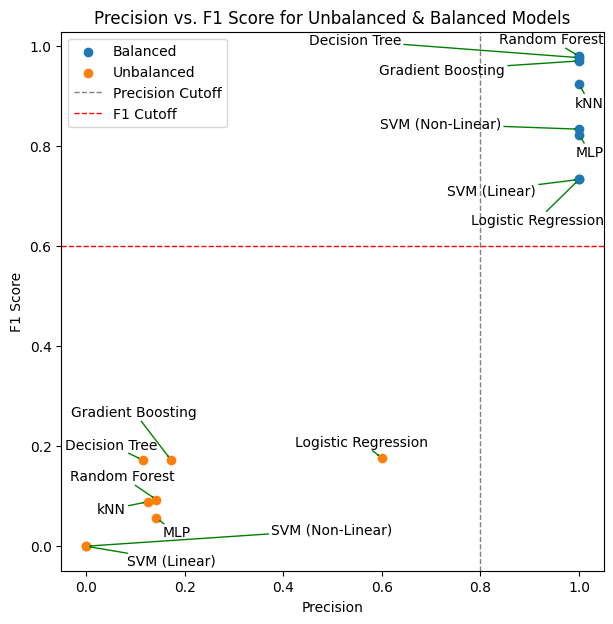

In [92]:
from adjustText import adjust_text

plt.figure(figsize=(7, 7))

balanced = scoring_df.loc[scoring_df['Balanced'] == True]
unbalanced = scoring_df.loc[scoring_df['Balanced'] == False]

plt.scatter(balanced['Precision'], balanced['F1 Score'])
plt.scatter(unbalanced['Precision'], unbalanced['F1 Score'])

f1 = 0.6
precision = 0.8

plt.axvline(x=precision, color='grey', linestyle='--', linewidth=1, label="Precision Cutoff")
plt.axhline(y=f1, color='red', linestyle='--', linewidth=1, label="F1 Cutoff")

texts = [plt.text(scoring_df['Precision'][i], scoring_df['F1 Score'][i], scoring_df['Model'][i], ha='right', va='center') for i in range(len(scoring_df))]
adjust_text(texts, expand=(2,2), arrowprops=dict(arrowstyle='->', color='green'))
plt.title('Precision vs. F1 Score for Unbalanced & Balanced Models')
plt.xlabel('Precision')
plt.ylabel('F1 Score')
plt.legend(['Balanced', 'Unbalanced', 'Precision Cutoff', 'F1 Cutoff'], ncol=1)
plt.show()

In [93]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

cv_obj = StratifiedKFold(n_splits=10)
def get_roc_data(model, cv_obj):
    curve_df = None
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train, test) in enumerate(cv_obj.split(X_adasyn, y_adasyn)):
        model.fit(X_adasyn.iloc[train], y_adasyn.iloc[train])
        scores = model.predict_proba(X_adasyn.iloc[test])[:,1]
        fpr, tpr, _ = roc_curve(y_adasyn.iloc[test],scores)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tmp = pd.DataFrame({'fold':i, 'fpr': mean_fpr, 'tpr': interp_tpr})
        curve_df = tmp if curve_df is None else pd.concat([curve_df, tmp])
        
        aucs.append(auc(fpr, tpr))
        
    curve_df = curve_df.groupby('fpr').agg({'tpr': 'mean'}).reset_index()
    curve_df.iloc[-1,1] = 1.0
    
    auc_df = pd.DataFrame({'fold': np.arange(len(aucs)), 'auc': aucs})
    return curve_df, auc_df

In [99]:
best_dt = DecisionTreeClassifier(**bal_clf_dtc_rfe_best_model[1])
dt_curve_df, dt_auc_df = get_roc_data(best_dt, cv_obj)
dt_curve_df['model'] = 'dt'
dt_auc_df['model'] = 'dt'

In [100]:
best_gb = GradientBoostingClassifier(**bal_clf_gb[1])
gb_curve_df,gb_auc_df = get_roc_data(best_gb, cv_obj)
gb_curve_df['model'] = 'gb'
gb_auc_df['model'] = 'gb'

/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

In [103]:
best_rf = RandomForestClassifier(**bal_clf_rfc_rfe_best_model[1])
rf_curve_df,rf_auc_df = get_roc_data(best_rf, cv_obj)
rf_curve_df['model'] = 'rf'
rf_auc_df['model'] = 'rf'

/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/danielcapra/Documents/WPI/CS539/.conda/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using r

In [104]:
# Combine the ROC curve data
curve_df = pd.concat([gb_curve_df, dt_curve_df, rf_curve_df])
auc_df = pd.concat([gb_auc_df, dt_auc_df, rf_auc_df])

mean_auc_per_model = auc_df.groupby('model')['auc'].mean().sort_values(ascending=False)
print(mean_auc_per_model)

model
rf    0.966602
gb    0.954592
dt    0.871127
Name: auc, dtype: float64


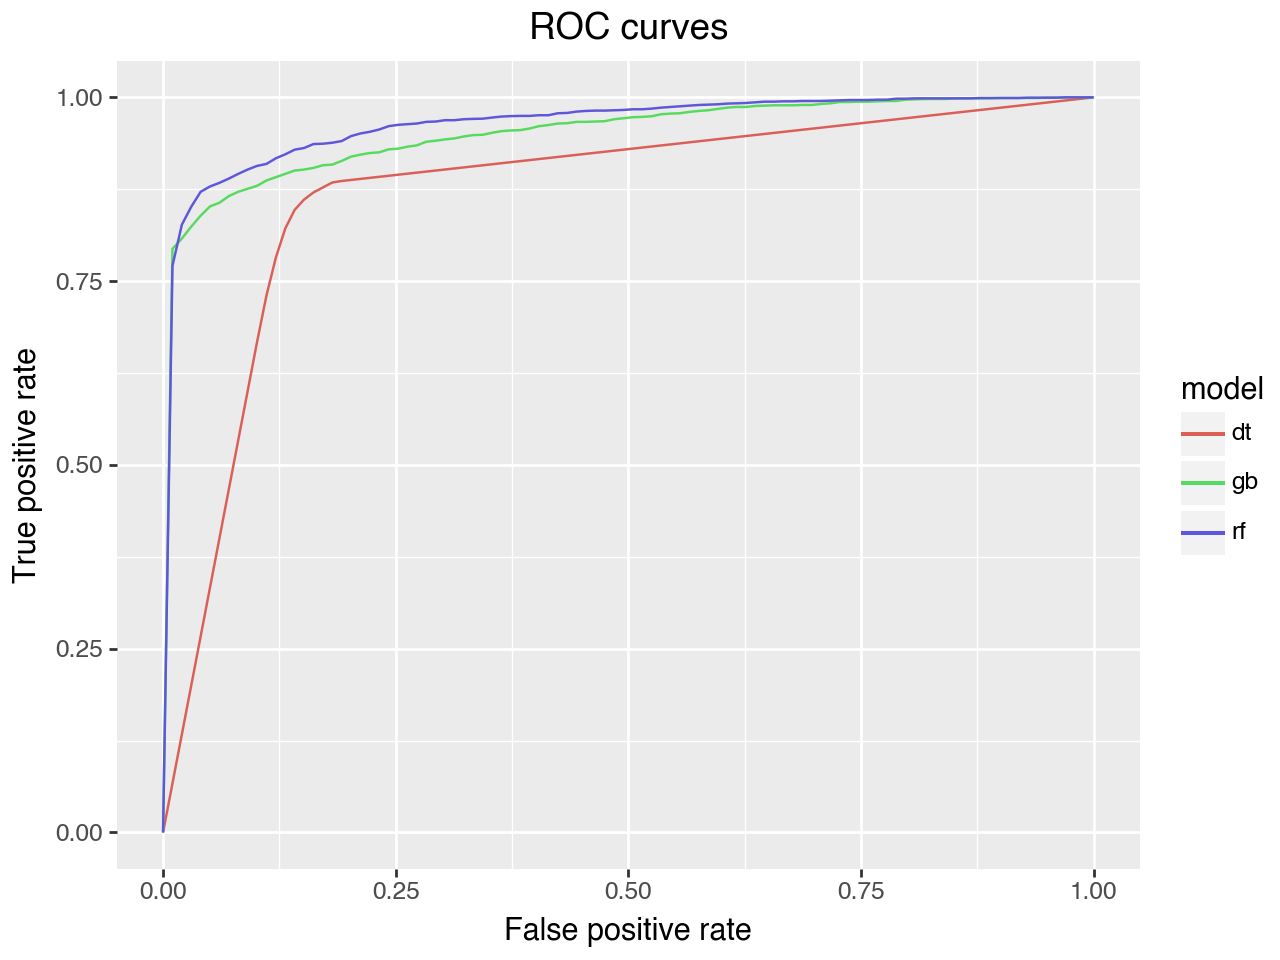

In [105]:
from plotnine import *

mean_curve_df = curve_df.groupby(['model','fpr']).agg({'tpr': 'mean'}).reset_index()
(ggplot(mean_curve_df, aes(x='fpr', y='tpr', color='model')) +
    geom_line() +
    labs(title = "ROC curves",
         x = "False positive rate",
         y = "True positive rate"))

## Full Analysis

To measure the performance of the research question, an emphasis has been placed on the F1-score of the models. The F1-score is particularly useful in unbalanced dataset such as the one in this problem. This harmonic is useful to evaluate the precision and recall of the models whereas the accuracy can be skewed by a bias in the dataset, leading to inaccurate assumptions about the model’s integrity. Precision is used as a secondary metric. Precision is useful for this use case because it will show the how many of the predicted All Stars are true All Stars. Falsely identifying a player as an All Star can have severe consequences for the financial health of a team because the team will be investing money in a player that is not worth it. Lastly, the top three models were evaluated using the mean AUC and ROC to see which model is the most robust.

Each model underwent recursive feature elimination to identify the features that would maximize the F1-score. The F1-score, accuracy, precision, and recall were all plotted from 1 to n features to show the progression of the metrics as more features were used to train the model (see `# of Features vs. Metric Score` graph below for the balanced Random Forest classifier). 

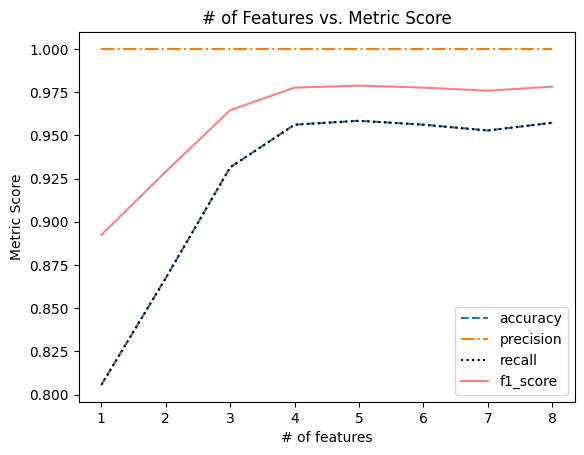

The best features were then used to do a cross-validation search for the best hyperparameters for the respective model. The metric of F1-score was also used when determining which hyperparameters maximized the model’s performance. In addition, the cross validation of the hyperparameter tuning ensured that each of the models had degree of robustness. The scoring for each of the models along with the best model features are shown in the table below.

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Model</th>
      <th>Balanced</th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1 Score</th>
      <th>RFE #</th>
      <th>RFE Features</th>
      <th>Best Params</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>12</th>
      <td>Random Forest</td>
      <td>True</td>
      <td>0.959551</td>
      <td>1.000000</td>
      <td>0.959551</td>
      <td>0.979358</td>
      <td>5</td>
      <td>[OvPck, Team, BirthState, YoD, DebutAge]</td>
      <td>{'ccp_alpha': 0.0, 'criterion': 'log_loss', 'max_depth': None, 'n_estimators': 10000}</td>
    </tr>
    <tr>
      <th>11</th>
      <td>Decision Tree</td>
      <td>True</td>
      <td>0.953933</td>
      <td>1.000000</td>
      <td>0.953933</td>
      <td>0.976423</td>
      <td>8</td>
      <td>[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]</td>
      <td>{'ccp_alpha': np.float64(0.0), 'criterion': 'gini', 'max_depth': None}</td>
    </tr>
    <tr>
      <th>15</th>
      <td>Gradient Boosting</td>
      <td>True</td>
      <td>0.941573</td>
      <td>1.000000</td>
      <td>0.941573</td>
      <td>0.969907</td>
      <td>8</td>
      <td>[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]</td>
      <td>{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 250}</td>
    </tr>
    <tr>
      <th>13</th>
      <td>kNN</td>
      <td>True</td>
      <td>0.858427</td>
      <td>1.000000</td>
      <td>0.858427</td>
      <td>0.923821</td>
      <td>8</td>
      <td>[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]</td>
      <td>{'metric': 'manhattan', 'n_neighbors': np.int64(5), 'weights': 'distance'}</td>
    </tr>
    <tr>
      <th>10</th>
      <td>SVM (Non-Linear)</td>
      <td>True</td>
      <td>0.714607</td>
      <td>1.000000</td>
      <td>0.714607</td>
      <td>0.833552</td>
      <td>8</td>
      <td>[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]</td>
      <td>{'C': np.float64(1.9000000000000001), 'gamma': 'auto'}</td>
    </tr>
    <tr>
      <th>14</th>
      <td>MLP</td>
      <td>True</td>
      <td>0.698876</td>
      <td>1.000000</td>
      <td>0.698876</td>
      <td>0.822751</td>
      <td>8</td>
      <td>[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]</td>
      <td>{'activation': 'tanh', 'hidden_layer_sizes': (100, 25), 'learning_rate': 'constant'}</td>
    </tr>
    <tr>
      <th>8</th>
      <td>Logistic Regression</td>
      <td>True</td>
      <td>0.578652</td>
      <td>1.000000</td>
      <td>0.578652</td>
      <td>0.733096</td>
      <td>1</td>
      <td>[College]</td>
      <td>{'C': np.float64(0.1), 'penalty': 'l2', 'solver': 'newton-cg'}</td>
    </tr>
    <tr>
      <th>9</th>
      <td>SVM (Linear)</td>
      <td>True</td>
      <td>0.578652</td>
      <td>1.000000</td>
      <td>0.578652</td>
      <td>0.733096</td>
      <td>1</td>
      <td>[College]</td>
      <td>{'C': np.float64(0.1), 'gamma': 'scale'}</td>
    </tr>
    <tr>
      <th>0</th>
      <td>Logistic Regression</td>
      <td>False</td>
      <td>0.945736</td>
      <td>0.600000</td>
      <td>0.103448</td>
      <td>0.176471</td>
      <td>7</td>
      <td>[OvPck, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]</td>
      <td>{'C': np.int64(4), 'penalty': 'l2', 'solver': 'newton-cg'}</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Decision Tree</td>
      <td>False</td>
      <td>0.813953</td>
      <td>0.114943</td>
      <td>0.344828</td>
      <td>0.172414</td>
      <td>5</td>
      <td>[OvPck, Team, BirthState, YoD, DebutAge]</td>
      <td>{'ccp_alpha': 0.0, 'criterion': 'log_loss', 'max_depth': None}</td>
    </tr>
    <tr>
      <th>7</th>
      <td>Gradient Boosting</td>
      <td>False</td>
      <td>0.906977</td>
      <td>0.172414</td>
      <td>0.172414</td>
      <td>0.172414</td>
      <td>8</td>
      <td>[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]</td>
      <td>{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 250}</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Random Forest</td>
      <td>False</td>
      <td>0.924419</td>
      <td>0.142857</td>
      <td>0.068966</td>
      <td>0.093023</td>
      <td>4</td>
      <td>[OvPck, Team, BirthState, DebutAge]</td>
      <td>{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'n_estimators': 500}</td>
    </tr>
    <tr>
      <th>5</th>
      <td>kNN</td>
      <td>False</td>
      <td>0.920543</td>
      <td>0.125000</td>
      <td>0.068966</td>
      <td>0.088889</td>
      <td>8</td>
      <td>[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]</td>
      <td>{'metric': 'manhattan', 'n_neighbors': np.int64(7), 'weights': 'distance'}</td>
    </tr>
    <tr>
      <th>6</th>
      <td>MLP</td>
      <td>False</td>
      <td>0.934109</td>
      <td>0.142857</td>
      <td>0.034483</td>
      <td>0.055556</td>
      <td>8</td>
      <td>[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]</td>
      <td>{'activation': 'tanh', 'hidden_layer_sizes': (300, 25), 'learning_rate': 'constant'}</td>
    </tr>
    <tr>
      <th>1</th>
      <td>SVM (Linear)</td>
      <td>False</td>
      <td>0.943798</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>1</td>
      <td>[RoundDrafted]</td>
      <td>{'C': np.float64(0.1), 'gamma': 'scale'}</td>
    </tr>
    <tr>
      <th>2</th>
      <td>SVM (Non-Linear)</td>
      <td>False</td>
      <td>0.922481</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>8</td>
      <td>[OvPck, Team, College, RoundDrafted, BirthCountry, BirthState, YoD, DebutAge]</td>
      <td>{'C': np.float64(1.8), 'gamma': 'auto'}</td>
    </tr>
  </tbody>
</table>
</div>

The model with the highest F1-score is the balanced Random Forest classifier with a score of 97.9%. This model has perfect precision and uses only five of eight input features. Perfect precision means that there were no falsely identified All Stars. Thus, all the players that were predicted to be All Stars were All Stars. The recall was 95.9% which shows that the model was also effective in limiting the number of false negatives (predicting a non-All Star but was actually an All Star). The features used for training and testing this model were reduced to overall pick, team, birth state, years of development, and debut age. The overall pick can indicate that picks that were drafted earlier have a greater probability of becoming All Stars which is supported by the exploratory data analysis. The team can indicate that certain organizations are better are at developing players or better at identifying All Stars. Knowledge about the birth state also indicates that players from California, Texas, and Florida had a higher probability of becoming All Stars. Years of development indicates most likely that players who spend less time in the Minor Leagues are more talented and more likely to become All Stars. Lastly, debut age for All Stars was approximately one year less than the average player. This could consider that the player could have been drafted out of high school or needed less development coming out of college.

As an overall observation, the balanced models all outperformed their unbalanced counterparts. This could be because there is too few All Stars in the data set (only 13%) to effectively determine if the player will become an All Star or not. The observation is supported by the `Precision vs. F1 Score for Unbalanced & Balanced Models` graph below. Notice that in the upper right quadrant of the scatter plot, all the models are balanced whereas all the unbalanced models have F1 scores below 50%. The models that made the precision and F1 score cutoff (in order of descending F1 score) are the balanced Random Forest, Decision Tree, Gradient Boosting, kNN, SVM (Non-linear), MLP, Logistic Regression, and SVM (Linear).

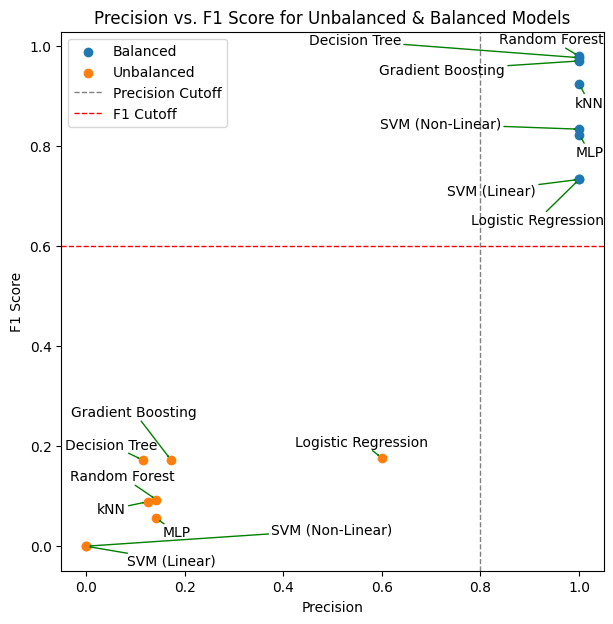

The top three models were then evaluated based on their ROC-AUC. For gathering the ROC-AUC data, the ADASYN training and testing sets where split into 10 folds. The models were then trained and tested on each fold to gather true positive rates and false positive rates. The Random Forest classifier had the highest mean AUC of 96.6% which indicates that it is the most robust algorithm in addition to the highest performing. The Gradient Boosting classifier (mean AUC of 95.5%) has a higher AUC than the Decision Tree classifier (mean AUC of 87.1%) which can indicates that it is more robust even though it was not higher performing according to the F1-Score and Precision metrics. The ROC curves for the three models are shown in Figure 3 which substantiates that the Random Forest classifier was the best model trained in this project because it was able to capture the most AUC and have the highest F1-score and precision.

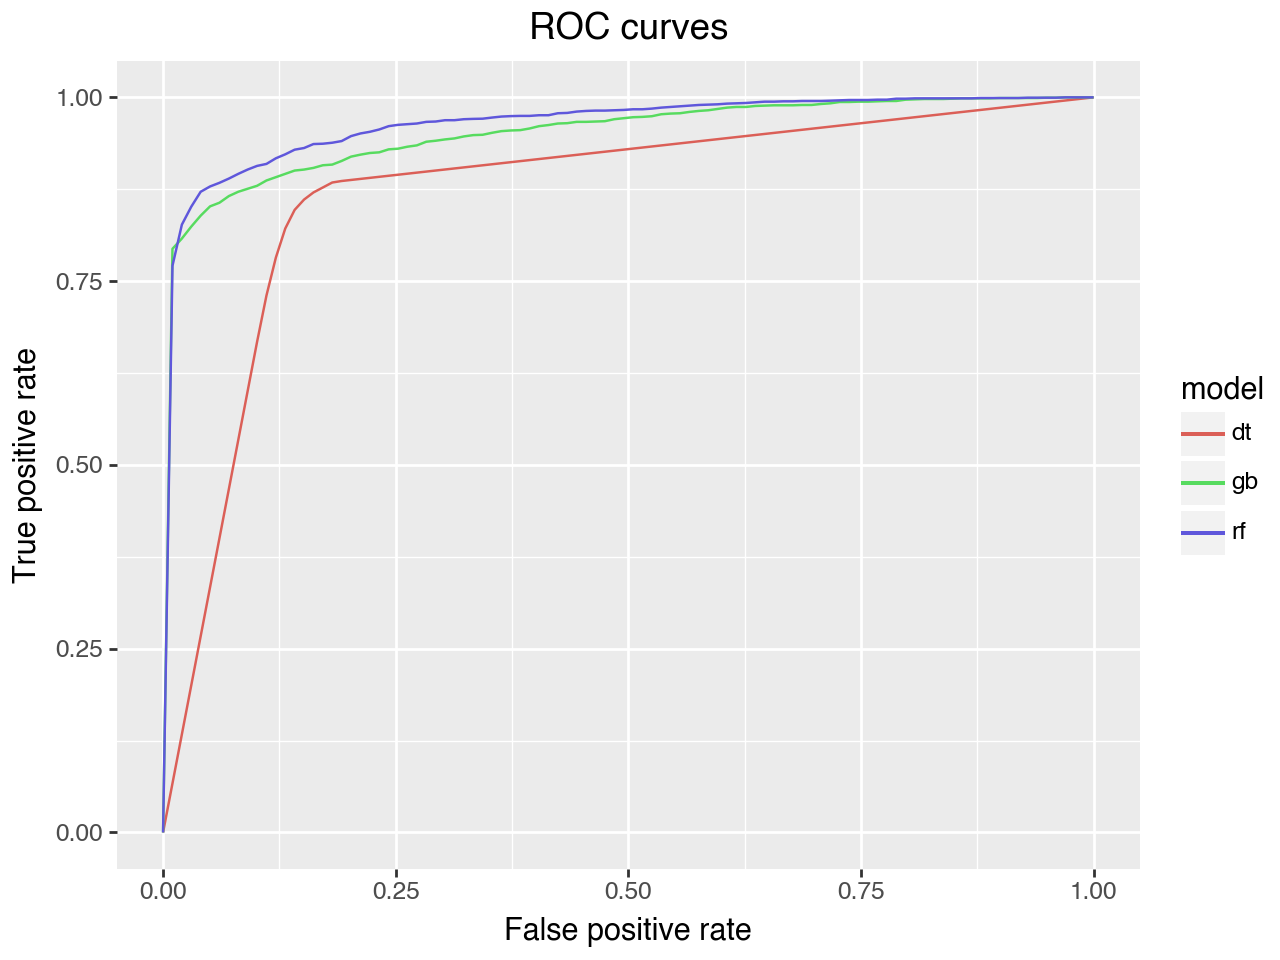